<a href="https://colab.research.google.com/github/SvenTern/algotrade/blob/main/%D0%9E%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D0%B5_%D0%B8%D0%B3%D1%80%D0%BE%D0%B2%D0%BE%D0%B9_%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B8_%D0%BE%D0%BF%D1%82%D0%B8%D0%BC%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D0%B8_%D0%BF%D0%BE%D1%80%D1%82%D1%84%D0%B5%D0%BB%D1%8F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Управление портфелем акций SP500***

# тестовый пример, будем строить на управлении пакетом акций AAPL, TSLA, NVDA
# период тестирования - май 2024 - декабрь 2024
#минутные интервалы

#у нас есть две обчуенные сетки :
#1) первая сеть предсказывает направление роста с вероятностью. 0-1
#каждая сеть обучена по отдельности на каждой акции
#2) вторая сеть предсказывает доходность в %
#у каждой сети еть обученный нормализатор - Scaler


# мы не будем делать ограничения по размеру вкладов, только попробуем завести ограничение как параметр

#сеть Finrl должна на входе получить :

#данные из реального датасета :
#нужно подумать и написать что конкретно

#1) цены акций за последние 5 интервалов
#2) волатильность
#3)

#Из размеченного датасета ⁉
#1)

#Из обученных моделей ⁉
#1) предсказание на текущий шаг, конкретно три вероятности
#2) предсказание дохода на текущий шаг
#3) значения TP, SL по формуле Келли


#Взять предел 2% входа по каждой акции
#Сделать трейнинг оптимизации портфеля, чтобы было 5 акций, с лимитом 20%
#Но нужно сделать оптимизацию, и на short-long


<a id='1'></a>
# Часть 2. Загрузка пакетов

<a id='1.1'></a>
## 2.1. Установка FinRL и MLlab


In [15]:
!pip install yfinance pandas numpy matplotlib
!pip install mplfinance
!pip install shimmy
!pip install -U polygon-api-client
!pip install selenium
!pip install webdriver-manager
!pip install alpaca-trade-api
!pip install alpaca-py
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git
#!pip install git+https://https://github.com/SvenTern/FinRL.git

#!pip install tensorflow
#!pip install scikeras


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.4/120.4 kB 3.2 MB/s eta 0:00:00
  Cloning https://github.com/AI4Finance-Foundation/FinRL.git to /tmp/pip-req-build-e9cmw3p_
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/FinRL.git /tmp/pip-req-build-e9cmw3p_
  Resolved https://github.com/AI4Finance-Foundation/FinRL.git to commit bc12fe7b57c483e8fac666f4cf05cbf62077958a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-4u4drhv5/elegantrl_c0e4245f877c4cd4a5c61276a69333c8
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/ElegantRL.git /tmp/pip-install-4u4drhv5/elegantrl_c0e4245f877c4cd4a5c61276a69333c8
  Resolved https://github.com/AI4Finance-Foundation/ElegantRL.git to commit 59d9a33e2b3ba2d77c052c2810bb61059736d88c
  Preparing m

In [7]:
!pip install --ignore-installed blinker
!pip install git+https://github.com/SvenTern/mllab.git

  Using cached blinker-1.9.0-py3-none-any.whl.metadata (1.6 kB)
Using cached blinker-1.9.0-py3-none-any.whl (8.5 kB)
  Cloning https://github.com/SvenTern/mllab.git to /tmp/pip-req-build-p3n_auml
  Running command git clone --filter=blob:none --quiet https://github.com/SvenTern/mllab.git /tmp/pip-req-build-p3n_auml
  Resolved https://github.com/SvenTern/mllab.git to commit 7fe6b243b03c88b3ffb2f0ca50bc10aade3ae6a4
  Preparing metadata (setup.py) ... done
  Created wheel for mllab: filename=mllab-1.4.124-py3-none-any.whl size=180444 sha256=4d9675310e6b59fc4782e38158bb9cae3e7f3b9264bc0c511404573345ee8b88
  Stored in directory: /tmp/pip-ephem-wheel-cache-sfbo9xg2/wheels/10/82/96/90fabce1d513480444cccf38a32c4ac823d44f8a8a18e26e89
Successfully built mllab
  Attempting uninstall: mllab
    Found existing installation: mllab 1.4.123
    Uninstalling mllab-1.4.123:
      Successfully uninstalled mllab-1.4.123


<a id='1.3'></a>
## 2.3. Импортируем библиотеки, подключаем google disk

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import datetime
from os.path import exists
import joblib as joblib
import json

import warnings
warnings.filterwarnings('ignore')

from finrl import config
from finrl import config_tickers
from finrl.meta.data_processors.processor_yahoofinance import YahooFinanceProcessor
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline, convert_daily_return_to_pyfolio_ts
from finrl.main import check_and_make_directories
from pprint import pprint
from stable_baselines3.common.logger import configure
import sys

# Import MlFinLab tools
from mllab.util.volatility import get_daily_vol
from mllab.filters.filters import cusum_filter
from mllab.labeling import labeling
from mllab.data_structures.preprocess_data import FinancePreprocessor, add_takeprofit_stoploss_volume
from mllab.labeling.trend_scanning import trend_scanning_labels
from mllab.labeling.labeling import check_trend_labels_with_period_length, short_long_box
from sklearn.ensemble import RandomForestClassifier
from mllab.ensemble.sb_bagging import SequentiallyBootstrappedBaggingClassifier
from mllab.cross_validation import score_confusion_matrix
from mllab.microstructural_features.feature_generator import calculate_indicators, get_correlation
from mllab.ensemble.model_train import ensemble_models, train_regression, train_bagging, StockPortfolioEnv


%matplotlib inline
# sys.path.append("../FinRL")

import pickle

import itertools

from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

from finrl.config_tickers import SP_500_TICKER, DOW_30_TICKER

from google.colab import drive
import os

# Подключение Google Диска
drive.mount('/content/drive')


# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [2]:
# Directory setup
check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])


# File paths and tickers
file_path = 'DOW30_1m'
list_tickers = ['AAPL', 'TSLA', 'NVDA']

coeff_tp = 1
coeff_sl = 1

short_period = 3
download = False

# Initialize processor
processor = FinancePreprocessor('polygon', list_tickers, "1Min", file_path)
data =  processor.clean_data(df = None, clean = True, required_columns=None)

if download:
    labels = processor.read_csv(f'labels {short_period}.csv')
else:
    labels = short_long_box(data, short_period = short_period)
    labels.to_csv(processor.file_path + f'labels {short_period}.csv', index=True)

print(labels['bin'].value_counts())

if download:
    indicators = processor.read_csv(f'indicators {short_period}.csv')
else:
    indicators = calculate_indicators(data)
    indicators.to_csv(processor.file_path + f'indicators {short_period}.csv', index=True)

Processing Groups: 100%|██████████| 3/3 [00:00<00:00, 50.40group/s]


bin
 0    267723
-1     15779
 1     14440
Name: count, dtype: int64


Processing tickers:   0%|          | 0/3 [00:00<?, ?it/s]

In [20]:
#data - полный датафрейм с тикерами tic и датой timestamp есть колонки open, low, high, close
#labels - разметка bin - направление роста или падения цены от предыдущего значения цены close когда поменялось направление тренда
#нужно написать функцию проверки разметки тренда нужно в цикле перебрать значения данных по тикерам отдельно, как если в этот момент зафиксировано в разметке изменение тренда брать предыдущую цену и сравнивать ее с ценой закрытия за данный период

# Пример вызова функции:
discrepancies = check_trend_labels_with_period_length(data, labels, short_period = short_period)
for d in discrepancies:
     print(d)


('AAPL', Timestamp('2024-05-03 10:03:00-0400', tz='UTC-04:00'), 33268, 'Несоответствие: тикер AAPL, ожидаемый рост, но цена упала с 184.115 до 183.62')
('AAPL', Timestamp('2024-05-03 10:04:00-0400', tz='UTC-04:00'), 33269, 'Несоответствие: тикер AAPL, ожидаемый рост, но цена упала с 184.115 до 183.62')
('AAPL', Timestamp('2024-05-03 10:05:00-0400', tz='UTC-04:00'), 33270, 'Несоответствие: тикер AAPL, ожидаемый рост, но цена упала с 184.115 до 183.62')
('AAPL', Timestamp('2024-05-03 10:06:00-0400', tz='UTC-04:00'), 33271, 'Несоответствие: тикер AAPL, ожидаемый рост, но цена упала с 184.115 до 183.62')
('AAPL', Timestamp('2024-05-03 10:07:00-0400', tz='UTC-04:00'), 33272, 'Несоответствие: тикер AAPL, ожидаемый рост, но цена упала с 184.115 до 183.62')
('AAPL', Timestamp('2024-06-10 14:38:00-0400', tz='UTC-04:00'), 43318, 'Несоответствие: тикер AAPL, ожидается падение, но цена выросла с 192.8895 до 193.185')
('AAPL', Timestamp('2024-07-15 09:56:00-0400', tz='UTC-04:00'), 52029, 'Несоответ

In [26]:
labels

,bin,vr_low,vr_high,return,period_length,tic
timestamp,,,,,,
2024-01-02 09:30:00-05:00,0,0.000000,0.000000,0.000000,0,AAPL
2024-01-02 09:31:00-05:00,0,0.000000,0.000000,0.000000,0,AAPL
2024-01-02 09:32:00-05:00,0,0.000000,0.000000,0.000000,0,AAPL
2024-01-02 09:33:00-05:00,0,0.000000,0.000000,0.000000,0,AAPL
2024-01-02 09:34:00-05:00,0,0.000000,0.000000,0.000000,0,AAPL
...,...,...,...,...,...,...
2025-01-03 15:56:00-05:00,-1,-0.005781,0.000461,-0.003862,2,TSLA
2025-01-03 15:57:00-05:00,-1,-0.005781,0.000461,-0.003862,1,TSLA
2025-01-03 15:58:00-05:00,0,0.000000,0.000000,0.000000,0,TSLA


In [3]:
# подготовим data для проверки разметки на торговле

# Исходная обработка
data_final = data[['open', 'low', 'high', 'close', 'tic']].copy()
data_final['date'] = data.index
data_final.sort_values(by=['date', 'tic'], inplace=True)
labels_final =  labels.copy()
labels_final.sort_values(by=['timestamp', 'tic'], inplace=True)
data_final['volatility'] = 1.0

# Сброс индексов для синхронизации строк
data_final.reset_index(drop=True, inplace=True)
labels_final.reset_index(drop=True, inplace=True)

# Присвоение новых столбцов
data_final[['bin', 'sl', 'tp']] = labels_final[['bin', 'vr_low', 'vr_high']]


stock_dimension = len(data.tic.unique())
risk_volume = 0.2

FEATURE_LENGTHS = {
    'prediction': 6,   # массив из 6 элементов
    'covariance': 3   # массив из 3 элементов
    # и т.д. для остальных feature...
}
# Constants and Transaction Cost Definitions
lookback = 5
features_list = ['prediction', 'covariance', 'volatility', 'last_return']
# 'base':0.0035 стоимость за акцию, 'minimal':0.35 минимальная комиссия в сделке, 'maximal':0.01 максимальный процент 1% комиссии, 'short_loan': 0.17 ставка займа в short 0.17% в день,
# 'short_rebate': 0.83 выплата rebate по коротким позициям 0.83% в день, 'short_rebate_limit':100000 лимит начиная с которого выплачивается rebate
transaction_cost_amount = {
    'base': 0.0035,
    'minimal': 0.35,
    'maximal': 0.01,
    'short_loan': 0.17,
    'short_rebate': 0.83,
    'short_rebate_limit': 100000
}
slippage = 0.02

env_kwargs = {
    "stock_dim": stock_dimension,
    "hmax": 100,
    'risk_volume': risk_volume,
    "initial_amount": 1000000,
    "transaction_cost_amount": transaction_cost_amount,
    "tech_indicator_list": [],
    'features_list': features_list,
    'FEATURE_LENGTHS' : FEATURE_LENGTHS,
    'use_logging': 1,
    'use_sltp' : True
}

e_train_gym = StockPortfolioEnv(df = data_final, **env_kwargs)

e_train_gym.__run__(type = 'label')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Игра по датам :: 100%|█████████▉| 99301/99314 [07:02<00:00, 156.75it/s]

day: 2025-01-03 16:00:00-05:00, episode: 0
begin_total_asset: 1000000.00
end_total_asset: 767837709.50
total_reward: 76683.77
maximal drowdown : 0.00


Annual Sharpe: 42.421


In [8]:
labels

,bin,vr_low,vr_high,return,period_length,tic
timestamp,,,,,,
2024-01-02 09:30:00-05:00,0,0.0,0.0,0.0,0,AAPL
2024-01-02 09:31:00-05:00,0,0.0,0.0,0.0,0,AAPL
2024-01-02 09:32:00-05:00,0,0.0,0.0,0.0,0,AAPL
2024-01-02 09:33:00-05:00,0,0.0,0.0,0.0,0,AAPL
2024-01-02 09:34:00-05:00,0,0.0,0.0,0.0,0,AAPL
...,...,...,...,...,...,...
2025-01-03 15:56:00-05:00,0,0.0,0.0,0.0,0,TSLA
2025-01-03 15:57:00-05:00,0,0.0,0.0,0.0,0,TSLA
2025-01-03 15:58:00-05:00,0,0.0,0.0,0.0,0,TSLA


In [ ]:
# нужно на базе текущеей идеальной разметки провести игру ...
# создать массив predictions
# запустить run

predictions = e_train_gym.__get_predictions__()

In [3]:
coeff_tp = 1
coeff_sl = 1

# нужно собрать из датасета indicators только колонки timestamp, tic
# потом сделать колонку prediction - которая есть массив из данных колонок bin-1, bin-0, bin+1, regression
data.sort_values(by=['timestamp', 'tic'], inplace=True)
indicators.sort_values(by=['timestamp', 'tic'], inplace=True)


# Собираем нужные колонки
data_prediction = data[['open', 'low', 'high','close','tic']].copy()
data_prediction.index = indicators.index

# Создаём новую колонку, в которую упакуем нужные значения в виде списка
data_prediction['prediction'] = indicators[['bin-1', 'bin-0', 'bin+1', 'regression']].values.tolist()

# Посмотрим на результат
#print(data_prediction.head())

data_prediction = add_takeprofit_stoploss_volume(data_prediction, coeff_tp=coeff_tp, coeff_sl=coeff_sl)

# Посмотрим на результат
print(data_prediction.head())

                               open       low      high     close   tic  \
timestamp                                                                 
2024-01-02 09:30:00-05:00  187.1500  186.3500  188.0500  187.8300  AAPL   
2024-01-02 09:30:00-05:00   49.2440   49.1188   49.2950   49.1710  NVDA   
2024-01-02 09:30:00-05:00  250.0800  249.5200  250.9000  249.9400  TSLA   
2024-01-02 09:31:00-05:00  187.8300  187.6300  188.1200  187.7650  AAPL   
2024-01-02 09:31:00-05:00   49.1662   49.0850   49.2665   49.1453  NVDA   

                                                                  prediction  
timestamp                                                                     
2024-01-02 09:30:00-05:00               [0.0, 0.9975, 0.0025, 0.0, 0.0, 0.0]  
2024-01-02 09:30:00-05:00                     [0.0, 1.0, 0.0, 0.0, 0.0, 0.0]  
2024-01-02 09:30:00-05:00               [0.0, 0.9965, 0.0035, 0.0, 0.0, 0.0]  
2024-01-02 09:31:00-05:00  [0.0935, 0.8320000000000001, 0.0745, 0.0, 0.0,...  


In [3]:
download = True

# Constants and Transaction Cost Definitions
lookback = 5
features_list = ['prediction', 'covariance', 'volatility', 'last_return']
# 'base':0.0035 стоимость за акцию, 'minimal':0.35 минимальная комиссия в сделке, 'maximal':0.01 максимальный процент 1% комиссии, 'short_loan': 0.17 ставка займа в short 0.17% в день,
# 'short_rebate': 0.83 выплата rebate по коротким позициям 0.83% в день, 'short_rebate_limit':100000 лимит начиная с которого выплачивается rebate
transaction_cost_amount = {
    'base': 0.0035,
    'minimal': 0.35,
    'maximal': 0.01,
    'short_loan': 0.17,
    'short_rebate': 0.83,
    'short_rebate_limit': 100000
}
slippage = 0.02

# Load or generate final prepared dataset
if download:
    data_final = processor.read_csv('final_final.csv')
    data_final.reset_index(inplace=True)
else:

    # превращаем в столбец 'timestamp'
    data_prediction.reset_index(inplace=True)
    data_prediction.rename(columns={'index': 'timestamp'}, inplace=True)

    # 1. Предобработка данных
    # Убедимся, что данные отсортированы по дате и тикерам:
    data_prediction.sort_values(['timestamp', 'tic'], inplace=True)
    data_prediction.reset_index(drop=True, inplace=True)

    print('data_prediction', data_prediction.head())
    # Группируем данные по тикеру и считаем процентное изменение (доходность)
    data_prediction['last_return'] = (
        data_prediction.groupby('tic')['close']
        .pct_change()
    )

    # Удаляем строки, где pct_change() не удалось посчитать (NaN для первых дат каждого тикера)
    data_prediction.dropna(inplace=True)

    # Извлекаем уникальные временные метки и список тикеров
    timestamps = data_prediction['timestamp'].unique()
    ticker_list = data_prediction['tic'].unique()

    # 2. Перекладываем данные в numpy-массив
    #    Теперь вместо 'diff' берём 'returns'
    data_np = data_prediction[['timestamp', 'tic', 'last_return']].values

    # Создаём словари, которые сопоставляют каждому timestamp и тикеру индекс в матрице
    timestamp_indices = {ts: idx for idx, ts in enumerate(timestamps)}
    ticker_indices = {tic: idx for idx, tic in enumerate(ticker_list)}

    # Инициализируем матрицу для наших доходностей
    returns_matrix_all = np.full((len(timestamps), len(ticker_list)), np.nan)
    for row in data_np:
        timestamp_val, tic_val, ret_val = row
        returns_matrix_all[timestamp_indices[timestamp_val], ticker_indices[tic_val]] = ret_val

    # 3. Основной цикл по временным меткам с учётом lookback
    results = []
    for i in range(lookback, len(timestamps)):
        current_timestamp = timestamps[i]
        # Берём окно [i - lookback, i) по строкам (датам)
        returns_matrix_window = returns_matrix_all[i - lookback:i, :]

        # Заменяем NaN на 0, чтобы избежать проблем при расчёте
        returns_matrix_window = np.nan_to_num(returns_matrix_window)

        # Считаем ковариацию между столбцами (столбец = тикер)
        covariance_matrix = np.cov(returns_matrix_window, rowvar=False)

        # Волатильность (стандартное отклонение) по каждому тикеру
        volatility_array = np.std(returns_matrix_window, axis=0)

        # returns_array — транспонированная матрица, чтобы строка соответствовала тикеру
        returns_array = returns_matrix_window.T

        # 4. Сбор результатов для каждого валидного тикера
        # Если у вас нет критерия "валидности",
        # то можно просто итерироваться по range(len(ticker_list))
        idx_valid = np.where(ticker_list)[0]
        for idx_ticker, ticker_idx in enumerate(idx_valid):
            results.append({
                'timestamp': current_timestamp,
                'tic': ticker_list[ticker_idx],
                # Пример сохранения ковариационной матрицы:
                # сохраняем только первую строку матрицы (или всю, если нужно)
                'covariance': (
                    covariance_matrix[0].tolist()
                    if covariance_matrix.ndim > 1
                    else [covariance_matrix.tolist()]
                ),
                'volatility': volatility_array[ticker_idx]
            })

    # 5. Формируем DataFrame с рассчитанными метриками
    cov_data = pd.DataFrame(results)

    # 6. Мерджим с исходным датафреймом
    data_final = data_prediction.merge(cov_data, on=['timestamp', 'tic'], how='left')
    data_final = data_final.sort_values(['timestamp', 'tic']).reset_index(drop=True)

    # Убираем первые (lookback) * количество_тикеров строк,
    # так как для них не хватает данных в начале
    data_final = data_final[(lookback) * len(ticker_list):]

    # Переименовываем столбец timestamp -> date для унификации
    data_final.rename(columns={'timestamp': 'date'}, inplace=True)

    # 7. Сохраняем полученный датасет в CSV
    # Преобразуем np.array в JSON строки
    data_final = data_final.applymap(lambda x: json.dumps(x.tolist()) if isinstance(x, np.ndarray) else x)
    data_final.to_csv(processor.file_path + 'final_final.csv', index=True)

In [4]:
data_final.iloc[41].prediction

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([ 0.0615    ,  0.2285    ,  0.71      ,  0.5915493 ,  0.00481602,
       -0.0019671 ])

<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.


## Training data split: TRAIN_START_DATE, TRAIN_END_DATE

In [2]:
if True:
    # Directory setup
    check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])


    # File paths and tickers
    file_path = 'DOW30_1m'
    list_tickers = ['AAPL', 'TSLA', 'NVDA']

    coeff_tp = 1
    coeff_sl = 1

    # Initialize processor
    processor = FinancePreprocessor('polygon', list_tickers, "1Min", file_path)
    train = processor.read_csv('train_final.csv')
    train.reset_index(inplace=True)
    # короткий датасет для тестирования
    #train = data_split(train, processor.convert_to_ny_time(processor.TRAIN_START_DATE), processor.convert_to_ny_time('2024-01-31'))
else:
    train = data_split(data_final, processor.convert_to_ny_time(processor.TRAIN_START_DATE), processor.convert_to_ny_time(processor.TRAIN_END_DATE))
    trade = data_split(data_final, processor.convert_to_ny_time(processor.TEST_START_DATE), processor.convert_to_ny_time(processor.TEST_END_DATE))

In [5]:
train.iloc[2].prediction

array([ 0.843     ,  0.0765    ,  0.0805    ,  0.81376038, -0.01292319,
       -0.00240681])

In [4]:
data = data_final

stock_dimension = len(data.tic.unique())
risk_volume = 0.2

FEATURE_LENGTHS = {
    'prediction': 6,   # массив из 6 элементов
    'covariance': 3   # массив из 3 элементов
    # и т.д. для остальных feature...
}
# Constants and Transaction Cost Definitions
lookback = 5
features_list = ['prediction', 'covariance', 'volatility', 'last_return']
# 'base':0.0035 стоимость за акцию, 'minimal':0.35 минимальная комиссия в сделке, 'maximal':0.01 максимальный процент 1% комиссии, 'short_loan': 0.17 ставка займа в short 0.17% в день,
# 'short_rebate': 0.83 выплата rebate по коротким позициям 0.83% в день, 'short_rebate_limit':100000 лимит начиная с которого выплачивается rebate
transaction_cost_amount = {
    'base': 0.0035,
    'minimal': 0.35,
    'maximal': 0.01,
    'short_loan': 0.17,
    'short_rebate': 0.83,
    'short_rebate_limit': 100000
}
slippage = 0.02

env_kwargs = {
    "stock_dim": stock_dimension,
    "hmax": 100,
    'risk_volume': risk_volume,
    "initial_amount": 1000000,
    "transaction_cost_amount": transaction_cost_amount,
    "tech_indicator_list": [],
    'features_list': features_list,
    'FEATURE_LENGTHS' : FEATURE_LENGTHS,
    'use_logging': 1,
    'use_sltp' : True
}

e_train_gym = StockPortfolioEnv(df = data, **env_kwargs)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Тикер: AAPL
По change_prev - Верных: 1271, Неверных: 697
По change_next - Верных: 950, Неверных: 1018

Тикер: NVDA
По change_prev - Верных: 1763, Неверных: 1011
По change_next - Верных: 1449, Неверных: 1325

Тикер: TSLA
По change_prev - Верных: 10229, Неверных: 5442
По change_next - Верных: 7756, Неверных: 7915


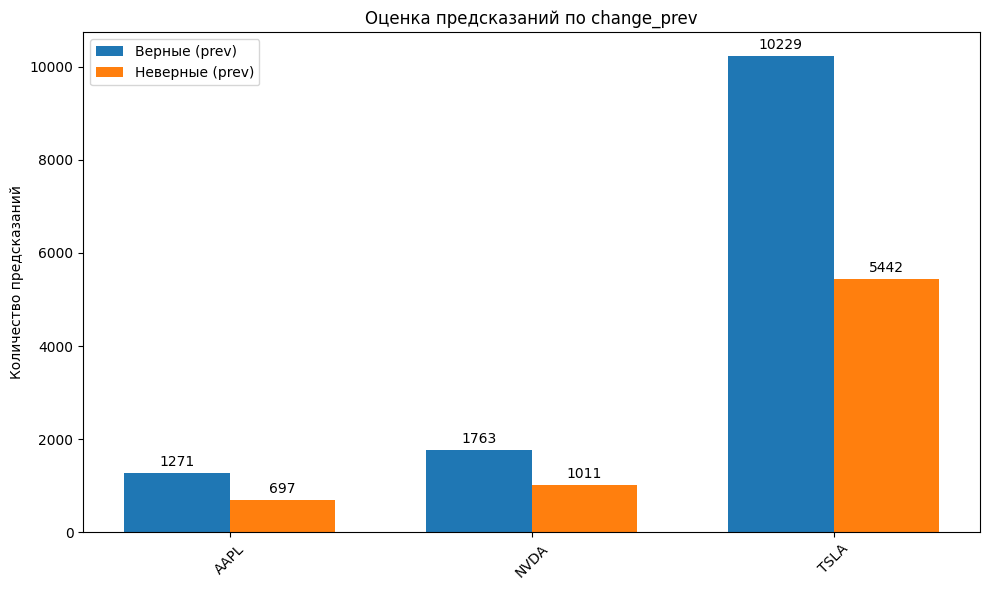

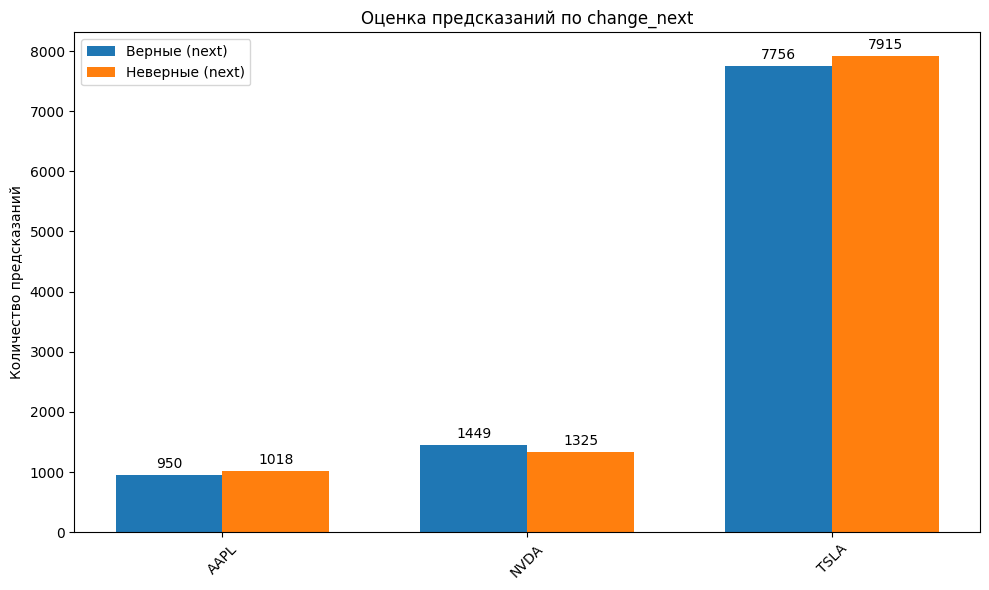

In [5]:
results_by_ticker = e_train_gym.__check__()

In [13]:
e_train_gym.logging_data[700:800]

['227: price 2 last_close: 248.28, open :248.295, low ;248.295, high :248.49, close :248.4462, stop_loss_price :248.280, take_profit_price :248.280 : cash :1,003,046 : value :1,003,046',
 '228: price 0 last_close: 185.415, open :185.415, low ;185.41, high :185.56, close :185.51, stop_loss_price :185.415, take_profit_price :185.415 : cash :1,003,046 : value :1,003,046',
 '228: price 1 last_close: 48.15, open :48.1499, low ;48.1413, high :48.185, close :48.168, stop_loss_price :48.150, take_profit_price :48.150 : cash :1,003,046 : value :1,003,046',
 '228: price 2 last_close: 248.4462, open :248.4482, low ;248.41, high :248.72, close :248.671, stop_loss_price :248.446, take_profit_price :248.446 : cash :1,003,046 : value :1,003,046',
 '229: price 0 last_close: 185.51, open :185.51, low ;185.47, high :185.54, close :185.485, stop_loss_price :185.510, take_profit_price :185.510 : cash :1,003,047 : value :1,003,047',
 '229: price 1 last_close: 48.168, open :48.168, low ;48.161, high :48.199

In [25]:
predictions = e_train_gym.__get_predictions__()

In [30]:
date0 = sorted(predictions.keys())[0]
actions = predictions[date0]
print(actions)

[[ 0.          0.          0.        ]
 [-0.85909869  0.00218208 -0.01548661]
 [-0.81376038  0.00240681 -0.01292319]]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [33]:
actions[:, 2]

array([ 0.        , -0.01548661, -0.01292319])

## Environment for Portfolio Allocation


In [ ]:
stock_dimension = len(train.tic.unique())
risk_volume = 0.2

FEATURE_LENGTHS = {
    'prediction': 6,   # массив из 6 элементов
    'covariance': 3   # массив из 3 элементов
    # и т.д. для остальных feature...
}

# Constants and Transaction Cost Definitions
lookback = 5
features_list = ['prediction', 'covariance', 'volatility', 'last_return']
# 'base':0.0035 стоимость за акцию, 'minimal':0.35 минимальная комиссия в сделке, 'maximal':0.01 максимальный процент 1% комиссии, 'short_loan': 0.17 ставка займа в short 0.17% в день,
# 'short_rebate': 0.83 выплата rebate по коротким позициям 0.83% в день, 'short_rebate_limit':100000 лимит начиная с которого выплачивается rebate
transaction_cost_amount = {
    'base': 0.0035,
    'minimal': 0.35,
    'maximal': 0.01,
    'short_loan': 0.17,
    'short_rebate': 0.83,
    'short_rebate_limit': 100000
}
slippage = 0.02
env_kwargs = {
    "stock_dim": stock_dimension,
    "hmax": 100,
    'risk_volume': risk_volume,
    "initial_amount": 1000000,
    "transaction_cost_amount": transaction_cost_amount,
    "tech_indicator_list": [],
    'features_list': features_list,
    'FEATURE_LENGTHS' : FEATURE_LENGTHS
}

# Extract unique timestamps and tickers
timestamps = train['date'].unique()
tickers = train['tic'].unique()

# Generate repeated action data for each ticker at each timestamp
actions_data = []
for timestamp in timestamps:
    for tic in tickers:
        actions_data.append({
            'date': timestamp,
            'tic': tic,
            'weight': np.random.uniform(-1, 1),  # Random portfolio weight (allows shorts)
            'stop_loss': np.random.uniform(0.01, 0.1),  # Random stop-loss percentage
            'take_profit': np.random.uniform(0.1, 0.2)  # Random take-profit percentage
        })

# Create a DataFrame from the list of dictionaries
df_actions = pd.DataFrame(actions_data)


e_train = StockPortfolioEnv(df = train, **env_kwargs)

for i in range(0):

    # Filter actions for the i timestamp
    second_timestamp = df_actions['date'].sort_values().unique()[i]  # Get the second timestamp
    second_actions = df_actions[df_actions['date'] == second_timestamp]

    # Prepare the actions as a NumPy array for the environment
    actions = second_actions[['weight', 'stop_loss', 'take_profit']].to_numpy()

    # Execute the second step
    state, reward, terminal, info = e_train.step(actions)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
stock_dimension = len(train.tic.unique())
risk_volume = 0.2

FEATURE_LENGTHS = {
    'prediction': 6,   # массив из 6 элементов
    'covariance': 3   # массив из 3 элементов
    # и т.д. для остальных feature...
}
# Constants and Transaction Cost Definitions
lookback = 5
features_list = ['prediction', 'covariance', 'volatility', 'last_return']
# 'base':0.0035 стоимость за акцию, 'minimal':0.35 минимальная комиссия в сделке, 'maximal':0.01 максимальный процент 1% комиссии, 'short_loan': 0.17 ставка займа в short 0.17% в день,
# 'short_rebate': 0.83 выплата rebate по коротким позициям 0.83% в день, 'short_rebate_limit':100000 лимит начиная с которого выплачивается rebate
transaction_cost_amount = {
    'base': 0.0035,
    'minimal': 0.35,
    'maximal': 0.01,
    'short_loan': 0.17,
    'short_rebate': 0.83,
    'short_rebate_limit': 100000
}
slippage = 0.02

env_kwargs = {
    "stock_dim": stock_dimension,
    "hmax": 100,
    'risk_volume': risk_volume,
    "initial_amount": 1000000,
    "transaction_cost_amount": transaction_cost_amount,
    "tech_indicator_list": [],
    'features_list': features_list,
    'FEATURE_LENGTHS' : FEATURE_LENGTHS,
    'use_logging': 0
}

e_train_gym = StockPortfolioEnv(df = train, **env_kwargs)

env_train, _ = e_train_gym.get_sb_env()
agent = DRLAgent(env = env_train)
A2C_PARAMS = {"n_steps": 5, "ent_coef": 0.01, "learning_rate": 0.0001}
model_a2c = agent.get_model(model_name="a2c",model_kwargs = A2C_PARAMS)

if False:
    trained_a2c = model_a2c.load(processor.file_path + 'trained_a2c.zip')
else:
    trained_a2c = agent.train_model(model=model_a2c,
                                tb_log_name='a2c',
                                total_timesteps=500000)
    trained_a2c.save(processor.file_path + 'trained_a2c.zip')



{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0001}
Using cuda device
--------------------------------------
| time/                 |            |
|    fps                | 147        |
|    iterations         | 100        |
|    time_elapsed       | 3          |
|    total_timesteps    | 500        |
| train/                |            |
|    entropy_loss       | -4.26      |
|    explained_variance | 3.71e-05   |
|    learning_rate      | 0.0001     |
|    n_updates          | 99         |
|    policy_loss        | -3.1e+04   |
|    reward             | -2209.4443 |
|    std                | 1          |
|    value_loss         | 5.41e+07   |
--------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 148        |
|    iterations         | 200        |
|    time_elapsed       | 6          |
|    total_timesteps    | 1000       |
| train/                |            |
|    entropy_loss       | -

KeyboardInterrupt: 

In [5]:
e_train_gym.logging_data[:100]

[]

In [6]:
e_train_gym.asset_memory[2]

{'cash': 1000132.9609078221,
 'portfolio_value': 1000132.9609078225,
 'holdings': array([0., 0., 0.])}

In [ ]:
# тестовая таблица

import pandas as pd
import numpy as np

# Define timestamps for 10 time steps
timestamps = [f'2024-01-01 09:30:{str(i).zfill(2)}' for i in range(10)]

# Define the tickers
tickers = ['AAPL', 'MSFT', 'GOOG']

# Generate repeated data for each ticker at each timestamp
data = []
for timestamp in timestamps:
    for tic in tickers:
        data.append({
            'timestamp': timestamp,
            'tic': tic,
            'open': np.random.uniform(100, 200),  # Random open price
            'high': np.random.uniform(200, 300),  # Random high price
            'low': np.random.uniform(50, 100),   # Random low price
            'close': np.random.uniform(100, 200),  # Random close price
            'volume': np.random.randint(1000, 10000),  # Random volume
            'trade_list': [0, 0, 0],  # Placeholder trade data
            'prediction_list': [0.3, 0.5, 0.2],  # Placeholder predictions
            'cov_list': np.eye(len(tickers)).tolist()  # Covariance matrix
        })

# Create a DataFrame from the list of dictionaries
df_sample = pd.DataFrame(data)

# Display the sample DataFrame
print(df_sample)

In [ ]:
stock_dimension = len(train.tic.unique())
state_space = stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 30, State Space: 30


In [ ]:
env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "transaction_cost_pct": 0.001,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": config.INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4

}

e_train_gym = StockPortfolioEnv(df = train, **env_kwargs)

In [ ]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

In [5]:
# initialize
agent = DRLAgent(env = env_train)

### Model 1: **A2C**


In [6]:
agent = DRLAgent(env = env_train)

A2C_PARAMS = {"n_steps": 5, "ent_coef": 0.005, "learning_rate": 0.0002}
model_a2c = agent.get_model(model_name="a2c",model_kwargs = A2C_PARAMS)

{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0002}
Using cuda device


In [9]:
if os.path.exists(processor.file_path + 'trained_a2c.zip'):
    trained_a2c = model_a2c.load(processor.file_path + 'trained_a2c.zip')
else:

    trained_a2c = agent.train_model(model=model_a2c,
                                tb_log_name='a2c',
                                total_timesteps=50000)
    trained_a2c.save(processor.file_path + 'trained_a2c.zip')

### Model 2: **PPO**


In [10]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.005,
    "learning_rate": 0.0001,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

{'n_steps': 2048, 'ent_coef': 0.005, 'learning_rate': 0.0001, 'batch_size': 128}
Using cuda device


In [11]:
if os.path.exists(processor.file_path + 'trained_ppo.zip'):
    trained_ppo = model_ppo.load(processor.file_path + 'trained_ppo.zip')
else:
    trained_ppo = agent.train_model(model=model_ppo,
                             tb_log_name='ppo',
                             total_timesteps=80000)
    trained_ppo.save(processor.file_path + 'trained_ppo.zip')


----------------------------------
| time/              |           |
|    fps             | 170       |
|    iterations      | 1         |
|    time_elapsed    | 11        |
|    total_timesteps | 2048      |
| train/             |           |
|    reward          | -785.9187 |
----------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 161           |
|    iterations           | 2             |
|    time_elapsed         | 25            |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 0.00021280683 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.26         |
|    explained_variance   | -2.38e-07     |
|    learning_rate        | 0.0001        |
|    loss                 | 2.99e+08      |
|    n_updates            | 10            |
|    policy_gradient_loss

### Model 3: **DDPG**


In [12]:
agent = DRLAgent(env = env_train)
DDPG_PARAMS = {"batch_size": 128, "buffer_size": 50000, "learning_rate": 0.001}


model_ddpg = agent.get_model("ddpg",model_kwargs = DDPG_PARAMS)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cuda device


In [13]:
if os.path.exists(processor.file_path + 'trained_ddpg.zip'):
    trained_ddpg = model_ddpg.load(processor.file_path + 'trained_ddpg.zip')
else:
    trained_ddpg = agent.train_model(model=model_ddpg,
                             tb_log_name='ddpg',
                             total_timesteps=50000)
    trained_ddpg.save(processor.file_path + 'trained_ddpg.zip')

### Model 4: **SAC**


In [ ]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0003,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0003, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cpu device


In [ ]:
if os.path.exists(processor.file_path + 'trained_sac.zip'):
    trained_sac = model_sac.load(processor.file_path + 'trained_sac.zip')
else:
    trained_sac = agent.train_model(model=model_sac,
                             tb_log_name='sac',
                             total_timesteps=50000)
    trained_sac.save(processor.file_path + 'trained_sac.zip')

begin_total_asset:1000000
end_total_asset:1026964.1830912211
Sharpe:  0.4548626634234428
begin_total_asset:1000000
end_total_asset:1026948.4469064932
Sharpe:  0.45484624968322906
begin_total_asset:1000000
end_total_asset:1026955.1163228963
Sharpe:  0.4549771563701922
begin_total_asset:1000000
end_total_asset:1026931.868001731
Sharpe:  0.45458433104998075
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 12        |
|    time_elapsed    | 1805      |
|    total_timesteps | 23400     |
| train/             |           |
|    actor_loss      | -6.75e+07 |
|    critic_loss     | 5.21e+10  |
|    ent_coef        | 103       |
|    ent_coef_loss   | -606      |
|    learning_rate   | 0.0003    |
|    n_updates       | 23299     |
|    reward          | 1026931.9 |
----------------------------------


KeyboardInterrupt: 

### Model 5: **TD3**


In [ ]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100,
              "buffer_size": 1000000,
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

In [ ]:
if os.path.exists(processor.file_path + 'trained_td3.zip'):
    trained_td3 = model_td3.load(folder_path + 'trained_td3.zip')
else:
    trained_td3 = agent.train_model(model=model_td3,
                             tb_log_name='td3',
                             total_timesteps=30000)
    trained_td3.save(processor.file_path + 'trained_td3.zip')

## Trading
Assume that we have $1,000,000 initial capital at 2019-01-01. We use the A2C model to trade Dow jones 30 stocks.

In [ ]:
#trade = data_split(df,'2020-07-01', '2021-10-31')
e_trade_gym = StockPortfolioEnv(df = trade, **env_kwargs)


In [ ]:
trade.shape

In [ ]:
df_daily_return, df_actions = DRLAgent.DRL_prediction(model=trained_a2c,
                        environment = e_trade_gym)

In [ ]:
df_daily_return.head()

In [ ]:
df_daily_return.to_csv('df_daily_return.csv')

In [ ]:
df_actions.head()

In [ ]:
df_actions.to_csv('df_actions.csv')

<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [ ]:
from pyfolio import timeseries
DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
perf_func = timeseries.perf_stats
perf_stats_all = perf_func( returns=DRL_strat,
                              factor_returns=DRL_strat,
                                positions=None, transactions=None, turnover_denom="AGB")

In [ ]:
print("==============DRL Strategy Stats===========")
perf_stats_all

==============DRL Strategy Stats===========


Annual return          0.296131
Cumulative returns     0.414639
Annual volatility      0.139606
Sharpe ratio           1.928505
Calmar ratio           3.347257
Stability              0.917786
Max drawdown          -0.088470
Omega ratio            1.380058
Sortino ratio          2.939907
Skew                  -0.111808
Kurtosis               1.453386
Tail ratio             1.095889
Daily value at risk   -0.016520
Alpha                  0.000000
Beta                   1.000000
dtype: float64

In [ ]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI",
        start = df_daily_return.loc[0,'date'],
        end = df_daily_return.loc[len(df_daily_return)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (337, 8)
Annual return          0.275227
Cumulative returns     0.384211
Annual volatility      0.138965
Sharpe ratio           1.824949
Calmar ratio           3.081783
Stability              0.919239
Max drawdown          -0.089308
Omega ratio            1.354658
Sortino ratio          2.705587
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.053708
Daily value at risk   -0.016502
dtype: float64


<a id='6.2'></a>
## 7.2 BackTestPlot

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (338, 8)


Start date,2020-07-01
End date,2021-10-29
Total months,16
,Backtest
Annual return,29.613%
Cumulative returns,41.464%
Annual volatility,13.961%
Sharpe ratio,1.93
Calmar ratio,3.35
Stability,0.92
Max drawdown,-8.847%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,8.85,2020-09-02,2020-10-28,2020-11-09,49
1,4.51,2021-08-16,2021-09-21,2021-10-19,47
2,4.15,2021-06-04,2021-06-18,2021-07-12,27
3,3.42,2021-01-20,2021-01-29,2021-02-05,13
4,3.19,2021-02-24,2021-03-04,2021-03-10,11


Stress Events,mean,min,max
New Normal,0.11%,-3.39%,3.98%


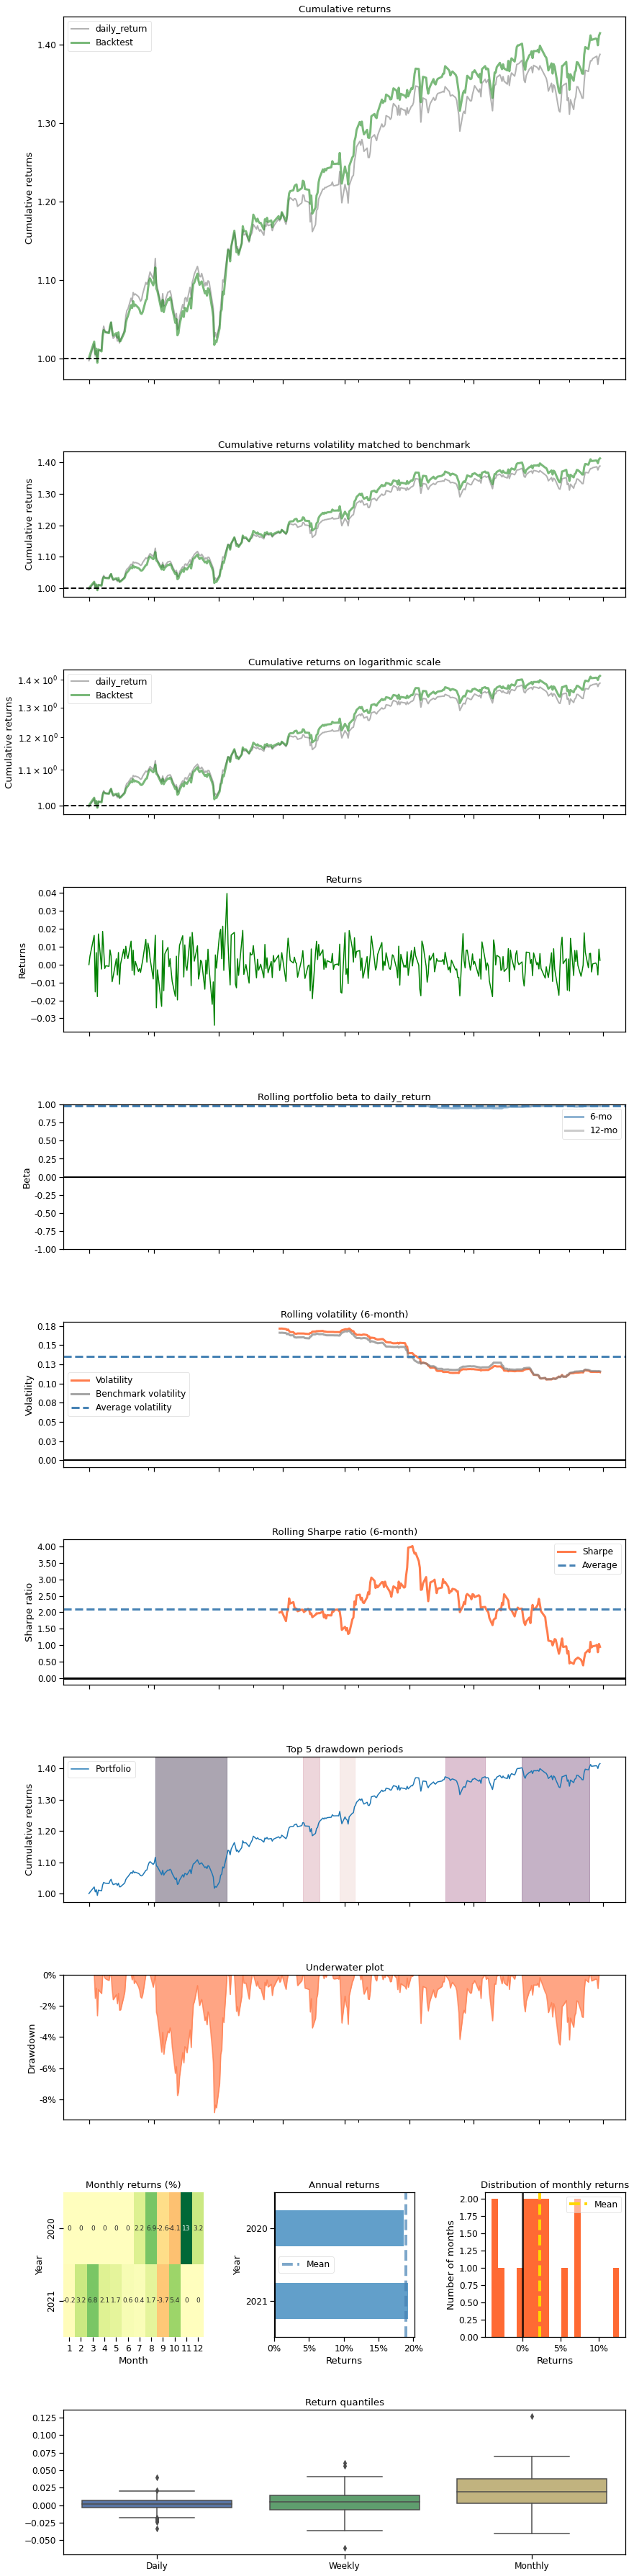

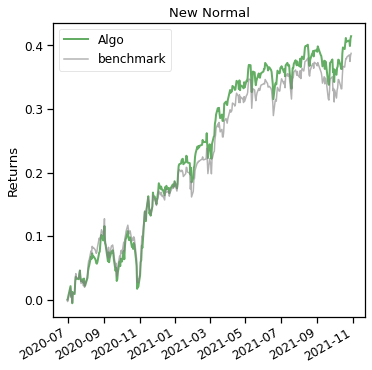

In [ ]:
import pyfolio
%matplotlib inline

baseline_df = get_baseline(
        ticker='^DJI', start=df_daily_return.loc[0,'date'], end='2021-11-01'
    )

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat,
                                       benchmark_rets=baseline_returns, set_context=False)

## Min-Variance Portfolio Allocation

In [ ]:
%pip install PyPortfolioOpt

In [ ]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models

In [ ]:
unique_tic = trade.tic.unique()
unique_trade_date = trade.date.unique()

In [ ]:
df.head()

,date,open,high,low,close,adjcp,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,cov_list,return_list
0,2008-12-30,3.122143,3.144643,3.025714,3.081786,2.638855,967601600,AAPL,1,-0.095139,3.647287,2.922999,42.673739,-80.272843,16.129793,3.246952,3.383500,"[[0.001349448862375765, 0.00042834220439268546...",tic AAPL AMGN AXP ...
1,2008-12-30,57.000000,57.660000,56.820000,57.590000,44.154682,4300800,AMGN,1,0.206630,59.373659,55.651341,50.840501,37.623751,17.245628,56.616000,55.998167,"[[0.001349448862375765, 0.00042834220439268546...",tic AAPL AMGN AXP ...
2,2008-12-30,17.820000,18.129999,17.700001,18.000000,14.507502,11777300,AXP,1,-1.263168,23.794809,16.256191,41.524298,-101.263980,33.966523,20.057333,22.604000,"[[0.001349448862375765, 0.00042834220439268546...",tic AAPL AMGN AXP ...
3,2008-12-30,40.080002,41.340000,39.810001,41.250000,30.940779,4549700,BA,1,-0.597202,42.590111,38.593890,45.299685,38.696627,7.693500,40.382334,43.448167,"[[0.001349448862375765, 0.00042834220439268546...",tic AAPL AMGN AXP ...
4,2008-12-30,42.570000,43.750000,42.009998,43.660000,30.079866,5060400,CAT,1,0.850860,45.671279,37.851721,49.916105,73.697581,19.456481,39.967000,39.993833,"[[0.001349448862375765, 0.00042834220439268546...",tic AAPL AMGN AXP ...


In [ ]:
#calculate_portfolio_minimum_variance
portfolio = pd.DataFrame(index = range(1), columns = unique_trade_date)
initial_capital = 1000000
portfolio.loc[0,unique_trade_date[0]] = initial_capital

for i in range(len( unique_trade_date)-1):
    df_temp = df[df.date==unique_trade_date[i]].reset_index(drop=True)
    df_temp_next = df[df.date==unique_trade_date[i+1]].reset_index(drop=True)
    #Sigma = risk_models.sample_cov(df_temp.return_list[0])
    #calculate covariance matrix
    Sigma = df_temp.return_list[0].cov()
    #portfolio allocation
    ef_min_var = EfficientFrontier(None, Sigma,weight_bounds=(0, 0.1))
    #minimum variance
    raw_weights_min_var = ef_min_var.min_volatility()
    #get weights
    cleaned_weights_min_var = ef_min_var.clean_weights()

    #current capital
    cap = portfolio.iloc[0, i]
    #current cash invested for each stock
    current_cash = [element * cap for element in list(cleaned_weights_min_var.values())]
    # current held shares
    current_shares = list(np.array(current_cash)
                                      / np.array(df_temp.close))
    # next time period price
    next_price = np.array(df_temp_next.close)
    ##next_price * current share to calculate next total account value
    portfolio.iloc[0, i+1] = np.dot(current_shares, next_price)

portfolio=portfolio.T
portfolio.columns = ['account_value']

In [ ]:
portfolio.head()

,account_value
2020-07-01,1000000
2020-07-02,1005234.883501
2020-07-06,1014933.780399
2020-07-07,1014238.666671
2020-07-08,1012674.038646


In [ ]:
a2c_cumpod =(df_daily_return.daily_return+1).cumprod()-1

In [ ]:
min_var_cumpod =(portfolio.account_value.pct_change()+1).cumprod()-1

In [ ]:
dji_cumpod =(baseline_returns+1).cumprod()-1

## Plotly: DRL, Min-Variance, DJIA

In [ ]:
%pip install plotly

In [ ]:
from datetime import datetime as dt

import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go

In [ ]:
time_ind = pd.Series(df_daily_return.date)

In [ ]:
trace0_portfolio = go.Scatter(x = time_ind, y = a2c_cumpod, mode = 'lines', name = 'A2C (Portfolio Allocation)')

trace1_portfolio = go.Scatter(x = time_ind, y = dji_cumpod, mode = 'lines', name = 'DJIA')
trace2_portfolio = go.Scatter(x = time_ind, y = min_var_cumpod, mode = 'lines', name = 'Min-Variance')
#trace3_portfolio = go.Scatter(x = time_ind, y = ddpg_cumpod, mode = 'lines', name = 'DDPG')
#trace4_portfolio = go.Scatter(x = time_ind, y = addpg_cumpod, mode = 'lines', name = 'Adaptive-DDPG')
#trace5_portfolio = go.Scatter(x = time_ind, y = min_cumpod, mode = 'lines', name = 'Min-Variance')

#trace4 = go.Scatter(x = time_ind, y = addpg_cumpod, mode = 'lines', name = 'Adaptive-DDPG')

#trace2 = go.Scatter(x = time_ind, y = portfolio_cost_minv, mode = 'lines', name = 'Min-Variance')
#trace3 = go.Scatter(x = time_ind, y = spx_value, mode = 'lines', name = 'SPX')

In [ ]:
fig = go.Figure()
fig.add_trace(trace0_portfolio)

fig.add_trace(trace1_portfolio)

fig.add_trace(trace2_portfolio)



fig.update_layout(
    legend=dict(
        x=0,
        y=1,
        traceorder="normal",
        font=dict(
            family="sans-serif",
            size=15,
            color="black"
        ),
        bgcolor="White",
        bordercolor="white",
        borderwidth=2

    ),
)
#fig.update_layout(legend_orientation="h")
fig.update_layout(title={
        #'text': "Cumulative Return using FinRL",
        'y':0.85,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
#with Transaction cost
#fig.update_layout(title =  'Quarterly Trade Date')
fig.update_layout(
#    margin=dict(l=20, r=20, t=20, b=20),

    paper_bgcolor='rgba(1,1,0,0)',
    plot_bgcolor='rgba(1, 1, 0, 0)',
    #xaxis_title="Date",
    yaxis_title="Cumulative Return",
xaxis={'type': 'date',
       'tick0': time_ind[0],
        'tickmode': 'linear',
       'dtick': 86400000.0 *80}

)
fig.update_xaxes(showline=True,linecolor='black',showgrid=True, gridwidth=1, gridcolor='LightSteelBlue',mirror=True)
fig.update_yaxes(showline=True,linecolor='black',showgrid=True, gridwidth=1, gridcolor='LightSteelBlue',mirror=True)
fig.update_yaxes(zeroline=True, zerolinewidth=1, zerolinecolor='LightSteelBlue')

fig.show()

## 4.2 Определение элементов, необходимых для расчета финансовых показателей
- Для получения более подробной информации описания данных набора данных, пожалуйста, посетите веб-сайт WRDS (https://wrds-www.wharton.upenn.edu/). Вам потребуется зарегистрироваться.

In [ ]:
# Список элементов, используемых для расчета финансовых показателей

items = [
    'datadate',  # Дата
    'tic',  # Тикер
    'oiadpq',  # Квартальная операционная прибыль
    'revtq',  # Квартальные доходы
    'niq',  # Квартальная чистая прибыль
    'atq',  # Всего активов
    'teqq',  # Собственный капитал
    'epspiy',  # Прибыль на акцию (базовая), включая внештатные элементы
    'ceqq',  # Общий капитал
    'cshoq',  # Общее количество обыкновенных акций
    'dvpspq',  # Дивиденды на акцию
    'actq',  # Оборотные активы
    'lctq',  # Оборотные пассивы
    'cheq',  # Денежные средства и их эквиваленты
    'rectq',  # Дебиторская задолженность
    'cogsq',  # Себестоимость проданных товаров
    'invtq',  # Инвентарь
    'apq',  # Кредиторская задолженность
    'dlttq',  # Долгосрочные обязательства
    'dlcq',  # Задолженность по текущим обязательствам
    'ltq'  # Пассивы
]

# Пропущены элементы, которые не будут использоваться
fund_data = fund[items]

In [ ]:
# Переименование названий столбцов для удобства
fund_data = fund_data.rename(columns={
    'datadate': 'date',  # Дата
    'oiadpq': 'op_inc_q',  # Квартальная операционная прибыль
    'revtq': 'rev_q',  # Квартальные доходы
    'niq': 'net_inc_q',  # Квартальная чистая прибыль
    'atq': 'tot_assets',  # Активы
    'teqq': 'sh_equity',  # Собственный капитал
    'epspiy': 'eps_incl_ex',  # Прибыль на акцию (базовая), включая внештатные элементы
    'ceqq': 'com_eq',  # Общий капитал
    'cshoq': 'sh_outstanding',  # Общее количество обыкновенных акций
    'dvpspq': 'div_per_sh',  # Дивиденды на акцию
    'actq': 'cur_assets',  # Оборотные активы
    'lctq': 'cur_liabilities',  # Оборотные пассивы
    'cheq': 'cash_eq',  # Денежные средства и их эквиваленты
    'rectq': 'receivables',  # Дебиторская задолженность
    'cogsq': 'cogs_q',  # Себестоимость проданных товаров
    'invtq': 'inventories',  # Инвентарь
    'apq': 'payables',  # Кредиторская задолженность
    'dlttq': 'long_debt',  # Долгосрочные обязательства
    'dlcq': 'short_debt',  # Задолженность по текущим обязательствам
    'ltq': 'tot_liabilities'  # Пассивы
})

In [ ]:
# Check the data
fund_data.head()

,date,tic,op_inc_q,rev_q,net_inc_q,tot_assets,sh_equity,eps_incl_ex,com_eq,sh_outstanding,...,cur_assets,cur_liabilities,cash_eq,receivables,cogs_q,inventories,payables,long_debt,short_debt,tot_liabilities
0,19990630,AXP,896.0,5564.0,646.0,132452.0,9762.0,2.73,9762.0,449.0,...,NaN,NaN,6096.0,46774.0,4668.0,448.0,22282.0,7005.0,24785.0,122690.0
1,19990930,AXP,906.0,5584.0,648.0,132616.0,9744.0,4.18,9744.0,447.6,...,NaN,NaN,5102.0,48827.0,4678.0,284.0,23587.0,6720.0,24683.0,122872.0
2,19991231,AXP,845.0,6009.0,606.0,148517.0,10095.0,5.54,10095.0,446.9,...,NaN,NaN,10391.0,54033.0,5164.0,277.0,25719.0,4685.0,32437.0,138422.0
3,20000331,AXP,920.0,6021.0,656.0,150662.0,10253.0,1.48,10253.0,444.7,...,NaN,NaN,7425.0,53663.0,5101.0,315.0,26379.0,5670.0,29342.0,140409.0
4,20000630,AXP,1046.0,6370.0,740.0,148553.0,10509.0,1.05,10509.0,1333.0,...,NaN,NaN,6841.0,54286.0,5324.0,261.0,29536.0,5336.0,26170.0,138044.0


## 4.3 Расчет финансовых показателей
- Для элементов из отчетов о прибылях и убытках мы рассчитываем LTM (Последние двенадцать месяцев) и используем их для выведения показателей, связанных с прибылью, таких как операционная маржа и ROE. Для элементов из балансов мы используем числа на определенный день.
- Для проверки определений расчитываемых здесь финансовых показателей, пожалуйста, обратитесь к веб-сайту CFI: https://corporatefinanceinstitute.com/resources/knowledge/finance/financial-ratios/

Используя имеющиеся показатели, мы рассчитываем 15 финансовых коэффициентов для отражения финансового состояния компаний. Список коэффициентов приведен ниже:
- Коэффициенты прибыльности: Операционная маржа, Чистая маржа, Рентабельность собственного капитала, Рентабельность активов
- Коэффициенты ликвидности: Текущая ликвидность, Коэффициент наличности, Быстрая ликвидность
- Коэффициенты эффективности: Коэффициент оборачиваемости запасов, Коэффициент оборачиваемости кредиторской задолженности, Коэффициент оборачиваемости дебиторской задолженности
- Финансовые коэффициенты кредитного плеча: Коэффициент долга, Коэффициент долга к собственному капиталу
- Коэффициенты оценки рынка: P/E, P/B, Дивидендная доходность

Нам необходимо рассчитать LTM (Последние двенадцать месяцев) для показателей из отчетов о прибылях и убытках, так как мы работаем с квартальными данными. Мы используем значения показателей из балансов, так как они представляют собой числа акций. Например, мы хотим рассчитать ROE к концу третьего квартала в финансовом году 2018 года. В числителе мы суммируем данные о чистой прибыли за четыре квартала.
(Числитель ROE) = Чистая прибыль Q4 2017 года + Q1 2018 года + Q2 2018 года + Q3 2018 года

Мы используем количество собственного капитала в качестве знаменателя на конец Q3 2018 года. То есть,
(Знаменатель ROE) = Собственный капитал на конец Q3 2018 года

Поскольку у нас еще нет данных о ценах на акции в DataFrame, мы рассчитываем только показатели на акцию, такие как прибыль на акцию, для расчета коэффициентов оценки рынка в конце этой части предварительной обработки.

Операционная маржа рассчитывается как отношение операционной прибыли к выручке и выражается в процентах.

Формула для расчета операционной маржи:
$$
\text{Operating Margin} = \frac{\text{Операционная прибыль}}{\text{Выручка}} \times 100\%
$$
Этот показатель позволяет оценить эффективность компании в генерации прибыли от своей основной деятельности. Величина операционной маржи показывает, сколько долларов операционной прибыли компания генерирует на каждый доллар выручки. Более высокие значения операционной маржи обычно указывают на более эффективное управление расходами и более высокую прибыльность бизнеса.


### Чистая прибыль к выручке (Чистая операционная маржа)

Чистая операционная маржа рассчитывается как отношение чистой прибыли к выручке и выражается в процентах.

Формула для расчета чистой операционной маржи:

$$
\text{Net Profit Margin} = \frac{\text{Чистая прибыль}}{\text{Выручка}} \times 100\%
$$

Этот показатель позволяет оценить, какая часть выручки превращается в чистую прибыль после учета всех операционных и неоперационных расходов. Чистая операционная маржа является важным показателем финансовой устойчивости и эффективности бизнеса. Высокие значения этого показателя свидетельствуют о том, что компания эффективно управляет своими расходами и генерирует значительную прибыль от своей деятельности.

### Рентабельность активов (ROA)

Рентабельность активов (ROA) рассчитывается как отношение чистой прибыли к общей сумме активов и выражается в процентах.

Формула для расчета ROA:

$$
\text{Return On Assets (ROA)} = \frac{\text{Чистая прибыль}}{\text{Общая сумма активов}} \times 100\%
$$

ROA показывает, сколько прибыли компания генерирует на каждый доллар активов. Этот показатель помогает инвесторам и аналитикам оценить эффективность использования активов компанией для генерации прибыли. Более высокие значения ROA указывают на более эффективное использование активов и, как следствие, на более высокую прибыльность компании.

### Рентабельность собственного капитала (ROE)

Рентабельность собственного капитала (ROE) рассчитывается как отношение чистой прибыли к собственному капиталу и выражается в процентах.

Формула для расчета ROE:

$$
\text{Return On Equity (ROE)} = \frac{\text{Чистая прибыль}}{\text{Собственный капитал}} \times 100\%
$$

ROE показывает, какую чистую прибыль компания генерирует на каждый доллар собственного капитала. Этот показатель помогает инвесторам и аналитикам оценить эффективность использования собственного капитала компанией для генерации прибыли. Более высокие значения ROE обычно указывают на более эффективное использование собственного капитала и, как следствие, на более высокую прибыльность компании.

### Прибыль на акцию (EPS)

Прибыль на акцию (EPS) рассчитывается как отношение чистой прибыли к общему количеству обыкновенных акций компании.

Формула для расчета EPS:

$$
\text{Earnings Per Share (EPS)} = \frac{\text{Чистая прибыль}}{\text{Общее количество обыкновенных акций}}
$$

EPS показывает, сколько долларов чистой прибыли приходится на одну акцию компании. Этот показатель является важным для инвесторов и аналитиков при оценке прибыльности и стоимости акций компании.

### Собственный капитал на акцию (Book Value Per Share)

Собственный капитал на акцию (Book Value Per Share) рассчитывается как отношение общего собственного капитала компании к общему количеству обыкновенных акций.

Формула для расчета Book Value Per Share:

$$
\text{Book Value Per Share} = \frac{\text{Собственный капитал}}{\text{Общее количество обыкновенных акций}}
$$

Book Value Per Share показывает, сколько долларов собственного капитала приходится на одну акцию компании. Этот показатель используется для оценки стоимости акций и может служить важным индикатором при принятии инвестиционных решений.

### Дивиденды на акцию (Dividends Per Share)

Дивиденды на акцию (Dividends Per Share) рассчитываются как отношение общей суммы выплаченных дивидендов к общему количеству обыкновенных акций.

Формула для расчета Dividends Per Share:

$$
\text{Dividends Per Share} = \frac{\text{Общая сумма выплаченных дивидендов}}{\text{Общее количество обыкновенных акций}}
$$

Dividends Per Share показывает, сколько долларов дивидендов выплачено на одну акцию компании. Этот показатель является важным для инвесторов, которые оценивают потенциальную доходность от дивидендов в связи с инвестициями в акции компании.

### Коэффициенты ликвидности

Коэффициенты ликвидности используются для оценки способности компании погасить свои текущие обязательства за счет доступных у нее активов. Они помогают инвесторам и кредиторам оценить финансовую устойчивость компании и ее способность к платежеспособности.

Наиболее распространенными коэффициентами ликвидности являются:

1. **Коэффициент текущей ликвидности (Current Ratio)**:
$$
\text{Current Ratio} = \frac{\text{Оборотные активы}}{\text{Оборотные пассивы}}
$$
Этот коэффициент показывает, сколько долларов оборотных активов приходится на один доллар оборотных пассивов. Чем выше значение этого коэффициента, тем лучше, так как это указывает на то, что у компании достаточно средств для покрытия своих текущих обязательств.

2. **Быстрый коэффициент ликвидности (Quick Ratio)**:
$$
\text{Quick Ratio} = \frac{\text{Оборотные активы} - \text{Запасы}}{\text{Оборотные пассивы}}
$$
Этот коэффициент исключает запасы из оборотных активов, поскольку запасы могут быть менее ликвидными и могут быть труднее реализовать. Таким образом, Quick Ratio предоставляет оценку ликвидности компании без учета запасов.

3. **Коэффициент абсолютной ликвидности (Absolute Liquidity Ratio)**:
$$
\text{Absolute Liquidity Ratio} = \frac{\text{Денежные средства и эквиваленты}}{\text{Оборотные пассивы}}
$$
Этот коэффициент показывает, какая доля оборотных пассивов компании покрывается ее денежными средствами и эквивалентами. Он оценивает способность компании к немедленному погашению текущих обязательств.

4. **Коэффициент денежной ликвидности (Cash Ratio)**

Коэффициент денежной ликвидности (Cash Ratio) - это мера ликвидности, которая оценивает способность компании погасить текущие обязательства только за счет ее наличных средств и их эквивалентов.

Формула для расчета Cash Ratio:
$$
\text{Cash Ratio} = \frac{\text{Денежные средства и их эквиваленты}}{\text{Оборотные пассивы}}
$$

Этот коэффициент показывает, какая часть оборотных пассивов компании покрывается ее наличными средствами и их эквивалентами. Более высокое значение коэффициента денежной ликвидности указывает на более высокую способность компании погасить свои текущие обязательства без необходимости привлечения дополнительных источников финансирования.

### Коэффициенты эффективности капитала
1. **Коэффициент оборачиваемости запасов (Inventory Turnover Ratio)**

Коэффициент оборачиваемости запасов (Inventory Turnover Ratio) измеряет, сколько раз за определенный период времени компания обновляет свой инвентарь. Этот показатель помогает оценить эффективность управления запасами компании и их оборачиваемость.

Формула для расчета Inventory Turnover Ratio:
$$
\text{Inventory Turnover Ratio} = \frac{\text{Себестоимость проданных товаров}}{\text{Средний объем запасов}}
$$

Где:
- Себестоимость проданных товаров представляет собой затраты, связанные с производством или приобретением товаров, которые были реализованы за рассматриваемый период времени.
- Средний объем запасов можно рассчитать как среднее арифметическое между начальным и конечным объемом запасов за период.

Высокий коэффициент оборачиваемости запасов обычно указывает на то, что компания эффективно управляет своим инвентарем, что может свидетельствовать о более здоровой финансовой позиции. Однако низкий коэффициент оборачиваемости запасов может указывать на проблемы с управлением запасами или на недостаточный спрос на товары компании.

2. **Коэффициент оборачиваемости дебиторской задолженности (Receivables Turnover Ratio)**

Коэффициент оборачиваемости дебиторской задолженности (Receivables Turnover Ratio) измеряет, сколько раз за определенный период времени компания обновляет свою дебиторскую задолженность. Этот показатель помогает оценить эффективность управления кредитными отношениями компании и скорость взыскания долгов.

Формула для расчета Receivables Turnover Ratio:
$$
\text{Receivables Turnover Ratio} = \frac{\text{Выручка}}{\text{Средний объем дебиторской задолженности}}
$$

Где:
- Выручка представляет собой общий объем продаж компании за рассматриваемый период времени.
- Средний объем дебиторской задолженности можно рассчитать как среднее арифметическое между начальным и конечным объемом дебиторской задолженности за период.

Высокий коэффициент оборачиваемости дебиторской задолженности обычно указывает на то, что компания эффективно управляет кредитными отношениями и активно взыскивает долги. Однако низкий коэффициент оборачиваемости дебиторской задолженности может свидетельствовать о проблемах с взысканием долгов или о неэффективном управлении кредитными отношениями.

3. **Коэффициент оборачиваемости кредиторской задолженности (Payable Turnover Ratio)**

Коэффициент оборачиваемости кредиторской задолженности (Payable Turnover Ratio) измеряет, сколько раз за определенный период времени компания обновляет свою кредиторскую задолженность. Этот показатель помогает оценить эффективность управления кредиторскими отношениями компании и ее скорость выплаты долгов.

Формула для расчета Payable Turnover Ratio:
$$
\text{Payable Turnover Ratio} = \frac{\text{Себестоимость проданных товаров}}{\text{Средний объем кредиторской задолженности}}
$$

Где:
- Себестоимость проданных товаров представляет собой затраты, связанные с производством или приобретением товаров, которые были реализованы за рассматриваемый период времени.
- Средний объем кредиторской задолженности можно рассчитать как среднее арифметическое между начальным и конечным объемом кредиторской задолженности за период.

Высокий коэффициент оборачиваемости кредиторской задолженности обычно указывает на то, что компания активно выплачивает свои долги поставщикам. Однако низкий коэффициент оборачиваемости кредиторской задолженности может свидетельствовать о проблемах с платежами или о неэффективном управлении кредиторскими отношениями.

### Финансовые коэффициенты кредитного плеча (Leverage Financial Ratios)

Финансовые коэффициенты кредитного плеча используются для оценки уровня финансового долга компании и ее способности управлять им. Эти показатели позволяют инвесторам и кредиторам оценить финансовую устойчивость компании и ее риск в отношении обязательств.

Наиболее распространенные финансовые коэффициенты кредитного плеча включают:

1. **Коэффициент финансового плеча (Debt-to-Equity Ratio)**:
$$
\text{Debt-to-Equity Ratio} = \frac{\text{Общий долг}}{\text{Собственный капитал}}
$$
Этот коэффициент показывает, сколько долларов долга приходится на один доллар собственного капитала. Он позволяет оценить, в какой степени компания финансируется за счет долга по сравнению с собственным капиталом.

2. **Коэффициент финансовой нагрузки (Financial Leverage Ratio)**:
$$
\text{Financial Leverage Ratio} = \frac{\text{Общий долг}}{\text{Общие активы}}
$$
Этот коэффициент показывает, какая часть активов компании финансируется за счет долга. Он помогает определить степень риска, связанного с использованием долгового финансирования.

3. **Коэффициент краткосрочной ликвидности (Short-term Debt Ratio)**:
$$
\text{Short-term Debt Ratio} = \frac{\text{Краткосрочный долг}}{\text{Общий долг}}
$$
Этот коэффициент показывает, какая доля долга компании является краткосрочным. Он помогает оценить финансовую стабильность компании в краткосрочной перспективе.

4. **Коэффициент капитализации долга (Debt Capitalization Ratio)**:
$$
\text{Debt Capitalization Ratio} = \frac{\text{Общий долг}}{\text{Общий долг} + \text{Собственный капитал}}
$$
Этот коэффициент показывает, какая часть капитализации компании приходится на долг. Он помогает оценить, в какой степени компания зависит от долга для финансирования своей деятельности.

In [ ]:
# Расчет финансовых показателей
date = pd.to_datetime(fund_data['date'],format='%Y%m%d')

tic = fund_data['tic'].to_frame('tic')

# Показатели рентабельности
# Операционная маржа (OPM)
OPM = pd.Series(np.empty(fund_data.shape[0],dtype=object),name='OPM')
for i in range(0, fund_data.shape[0]):
    if i-3 < 0:
        OPM[i] = np.nan
    elif fund_data.iloc[i,1] != fund_data.iloc[i-3,1]:
        OPM.iloc[i] = np.nan
    else:
        OPM.iloc[i] = np.sum(fund_data['op_inc_q'].iloc[i-3:i])/np.sum(fund_data['rev_q'].iloc[i-3:i])

# Чистая операционная маржа (NPM)
NPM = pd.Series(np.empty(fund_data.shape[0],dtype=object),name='NPM')
for i in range(0, fund_data.shape[0]):
    if i-3 < 0:
        NPM[i] = np.nan
    elif fund_data.iloc[i,1] != fund_data.iloc[i-3,1]:
        NPM.iloc[i] = np.nan
    else:
        NPM.iloc[i] = np.sum(fund_data['net_inc_q'].iloc[i-3:i])/np.sum(fund_data['rev_q'].iloc[i-3:i])

# Рентабельность активов (ROA)
ROA = pd.Series(np.empty(fund_data.shape[0],dtype=object),name='ROA')
for i in range(0, fund_data.shape[0]):
    if i-3 < 0:
        ROA[i] = np.nan
    elif fund_data.iloc[i,1] != fund_data.iloc[i-3,1]:
        ROA.iloc[i] = np.nan
    else:
        ROA.iloc[i] = np.sum(fund_data['net_inc_q'].iloc[i-3:i])/fund_data['tot_assets'].iloc[i]

# Рентабельность собственного капитала (ROE)
ROE = pd.Series(np.empty(fund_data.shape[0],dtype=object),name='ROE')
for i in range(0, fund_data.shape[0]):
    if i-3 < 0:
        ROE[i] = np.nan
    elif fund_data.iloc[i,1] != fund_data.iloc[i-3,1]:
        ROE.iloc[i] = np.nan
    else:
        ROE.iloc[i] = np.sum(fund_data['net_inc_q'].iloc[i-3:i])/fund_data['sh_equity'].iloc[i]

# Для расчета коэффициентов оценки в следующем подразделе предварительно рассчитайте показатели на одну акцию
# Прибыль на акцию (EPS)
EPS = fund_data['eps_incl_ex'].to_frame('EPS')

# Собственный капитал на акцию (Book Value Per Share)
BPS = (fund_data['com_eq']/fund_data['sh_outstanding']).to_frame('BPS') # Need to check units

# Дивиденды на акцию (Dividends Per Share)
DPS = fund_data['div_per_sh'].to_frame('DPS')

# Коэффициенты ликвидности
# Коэффициент текущей ликвидности (Current Ratio)
cur_ratio = (fund_data['cur_assets']/fund_data['cur_liabilities']).to_frame('cur_ratio')

# Быстрый коэффициент ликвидности (Quick Ratio)
quick_ratio = ((fund_data['cash_eq'] + fund_data['receivables'] )/fund_data['cur_liabilities']).to_frame('quick_ratio')

# Коэффициент денежной ликвидности (Cash Ratio)
cash_ratio = (fund_data['cash_eq']/fund_data['cur_liabilities']).to_frame('cash_ratio')


# Коэффициенты эффективности
# Коэффициент оборачиваемости запасов (Inventory Turnover Ratio)
inv_turnover = pd.Series(np.empty(fund_data.shape[0],dtype=object),name='inv_turnover')
for i in range(0, fund_data.shape[0]):
    if i-3 < 0:
        inv_turnover[i] = np.nan
    elif fund_data.iloc[i,1] != fund_data.iloc[i-3,1]:
        inv_turnover.iloc[i] = np.nan
    else:
        inv_turnover.iloc[i] = np.sum(fund_data['cogs_q'].iloc[i-3:i])/fund_data['inventories'].iloc[i]

# Коэффициент оборачиваемости дебиторской задолженности (Receivables Turnover Ratio)
acc_rec_turnover = pd.Series(np.empty(fund_data.shape[0],dtype=object),name='acc_rec_turnover')
for i in range(0, fund_data.shape[0]):
    if i-3 < 0:
        acc_rec_turnover[i] = np.nan
    elif fund_data.iloc[i,1] != fund_data.iloc[i-3,1]:
        acc_rec_turnover.iloc[i] = np.nan
    else:
        acc_rec_turnover.iloc[i] = np.sum(fund_data['rev_q'].iloc[i-3:i])/fund_data['receivables'].iloc[i]

# Коэффициент оборачиваемости кредиторской задолженности (Payable Turnover Ratio)
acc_pay_turnover = pd.Series(np.empty(fund_data.shape[0],dtype=object),name='acc_pay_turnover')
for i in range(0, fund_data.shape[0]):
    if i-3 < 0:
        acc_pay_turnover[i] = np.nan
    elif fund_data.iloc[i,1] != fund_data.iloc[i-3,1]:
        acc_pay_turnover.iloc[i] = np.nan
    else:
        acc_pay_turnover.iloc[i] = np.sum(fund_data['cogs_q'].iloc[i-3:i])/fund_data['payables'].iloc[i]

## Коэффициенты кредитного плеча (Leverage Financial Ratios)
# Коэффициент капитализации долга (Debt Capitalization Ratio)
debt_ratio = (fund_data['tot_liabilities']/fund_data['tot_assets']).to_frame('debt_ratio')

# Коэффициент финансового плеча (Debt-to-Equity Ratio)
debt_to_equity = (fund_data['tot_liabilities']/fund_data['sh_equity']).to_frame('debt_to_equity')

In [ ]:
# Соберем датафрейм со всеми рассчитанными показателями
ratios = pd.concat([date,tic,OPM,NPM,ROA,ROE,EPS,BPS,DPS,
                    cur_ratio,quick_ratio,cash_ratio,inv_turnover,acc_rec_turnover,acc_pay_turnover,
                   debt_ratio,debt_to_equity], axis=1)

In [ ]:
# Check the ratio data
ratios.head()

,date,tic,OPM,NPM,ROA,ROE,EPS,BPS,DPS,cur_ratio,quick_ratio,cash_ratio,inv_turnover,acc_rec_turnover,acc_pay_turnover,debt_ratio,debt_to_equity
0,1999-06-30,AXP,NaN,NaN,NaN,NaN,2.73,21.741648,0.225,NaN,NaN,NaN,NaN,NaN,NaN,0.926298,12.568121
1,1999-09-30,AXP,NaN,NaN,NaN,NaN,4.18,21.769437,0.225,NaN,NaN,NaN,NaN,NaN,NaN,0.926525,12.610016
2,1999-12-31,AXP,NaN,NaN,NaN,NaN,5.54,22.588946,0.225,NaN,NaN,NaN,NaN,NaN,NaN,0.932028,13.711937
3,2000-03-31,AXP,0.154281,0.110742,0.012611,0.185312,1.48,23.055993,0.225,NaN,NaN,NaN,46.063492,0.319717,0.550059,0.931947,13.694431
4,2000-06-30,AXP,0.151641,0.108436,0.012857,0.181749,1.05,7.883721,0.080,NaN,NaN,NaN,57.252874,0.324467,0.505925,0.929258,13.135788


In [ ]:
ratios.tail()

,date,tic,OPM,NPM,ROA,ROE,EPS,BPS,DPS,cur_ratio,quick_ratio,cash_ratio,inv_turnover,acc_rec_turnover,acc_pay_turnover,debt_ratio,debt_to_equity
2451,2020-03-31,V,0.667517,0.521213,0.129058,0.271736,2.85,13.647142,0.30,1.248714,1.140070,0.955150,inf,6.11635,2.697537,0.525062,1.105537
2452,2020-06-30,V,0.668385,0.519867,0.120448,0.264075,3.92,14.203947,0.30,1.553478,1.443292,1.221925,inf,5.063131,1.889507,0.543886,1.192433
2453,2020-09-30,V,0.654464,0.52129,0.107873,0.241066,4.90,14.653484,0.30,1.905238,1.784838,1.579807,inf,5.628571,2.730366,0.552515,1.234714
2454,2020-12-31,V,0.638994,0.480876,0.094422,0.201545,1.42,15.908283,0.32,2.121065,1.969814,1.700081,inf,4.725314,2.347866,0.531507,1.134505
2455,2021-03-31,V,0.640128,0.488704,0.095218,0.202568,2.80,16.088525,0.32,2.116356,1.954292,1.700574,inf,4.844961,2.367357,0.529946,1.127414


## 4.4 Обработка пропусков
Заменим пропуски и NA на ноль.

In [ ]:
# Replace NAs infinite values with zero
final_ratios = ratios.copy()
final_ratios = final_ratios.fillna(0)
final_ratios = final_ratios.replace(np.inf,0)

In [ ]:
final_ratios.head()

,date,tic,OPM,NPM,ROA,ROE,EPS,BPS,DPS,cur_ratio,quick_ratio,cash_ratio,inv_turnover,acc_rec_turnover,acc_pay_turnover,debt_ratio,debt_to_equity
0,1999-06-30,AXP,0.000000,0.000000,0.000000,0.000000,2.73,21.741648,0.225,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.926298,12.568121
1,1999-09-30,AXP,0.000000,0.000000,0.000000,0.000000,4.18,21.769437,0.225,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.926525,12.610016
2,1999-12-31,AXP,0.000000,0.000000,0.000000,0.000000,5.54,22.588946,0.225,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.932028,13.711937
3,2000-03-31,AXP,0.154281,0.110742,0.012611,0.185312,1.48,23.055993,0.225,0.0,0.0,0.0,46.063492,0.319717,0.550059,0.931947,13.694431
4,2000-06-30,AXP,0.151641,0.108436,0.012857,0.181749,1.05,7.883721,0.080,0.0,0.0,0.0,57.252874,0.324467,0.505925,0.929258,13.135788


In [ ]:
final_ratios.tail()

,date,tic,OPM,NPM,ROA,ROE,EPS,BPS,DPS,cur_ratio,quick_ratio,cash_ratio,inv_turnover,acc_rec_turnover,acc_pay_turnover,debt_ratio,debt_to_equity
2451,2020-03-31,V,0.667517,0.521213,0.129058,0.271736,2.85,13.647142,0.30,1.248714,1.140070,0.955150,0.0,6.116350,2.697537,0.525062,1.105537
2452,2020-06-30,V,0.668385,0.519867,0.120448,0.264075,3.92,14.203947,0.30,1.553478,1.443292,1.221925,0.0,5.063131,1.889507,0.543886,1.192433
2453,2020-09-30,V,0.654464,0.521290,0.107873,0.241066,4.90,14.653484,0.30,1.905238,1.784838,1.579807,0.0,5.628571,2.730366,0.552515,1.234714
2454,2020-12-31,V,0.638994,0.480876,0.094422,0.201545,1.42,15.908283,0.32,2.121065,1.969814,1.700081,0.0,4.725314,2.347866,0.531507,1.134505
2455,2021-03-31,V,0.640128,0.488704,0.095218,0.202568,2.80,16.088525,0.32,2.116356,1.954292,1.700574,0.0,4.844961,2.367357,0.529946,1.127414


## 4.5 Соберем все вместе с ценами в итоговый датасет для моделирования
- Объединим DataFrame с ценами, предварительно обработанный в части 3, и DataFrame с коэффициентами, созданный в этой части.
- Поскольку цены представлены ежедневно, а коэффициенты - квартально, после объединения двух DataFrame в столбцах с коэффициентами будут пропущенные значения. Мы решаем эту проблему, заполняя пропущенные значения последним известным значением коэффициента.

In [ ]:
list_ticker = df["tic"].unique().tolist()
list_date = list(pd.date_range(df['date'].min(),df['date'].max()))
combination = list(itertools.product(list_date,list_ticker))

# Merge stock price data and ratios into one dataframe
processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(df,on=["date","tic"],how="left")
processed_full = processed_full.merge(final_ratios,how='left',on=['date','tic'])
processed_full = processed_full.sort_values(['tic','date'])

# Backfill the ratio data to make them daily
processed_full = processed_full.bfill(axis='rows')


## 4.6 Рассчитать рыночные оценочные коэффициенты, используя ежедневные данные о ценах на акции.

In [ ]:
# Рассчитайте коэффициенты P/E (цена/прибыль), P/B (цена/балансовая стоимость) и дивидендную доходность с использованием ежедневной цены закрытия.
processed_full['PE'] = processed_full['close']/processed_full['EPS']
processed_full['PB'] = processed_full['close']/processed_full['BPS']
processed_full['Div_yield'] = processed_full['DPS']/processed_full['close']

# Удалим показатели на одну акцию, использованные для расчета коэффициентов.
processed_full = processed_full.drop(columns=['day','EPS','BPS','DPS'])

# Заменить пропуски нулями
processed_full = processed_full.copy()
processed_full = processed_full.fillna(0)
processed_full = processed_full.replace(np.inf,0)

In [ ]:
# посмотрим на финальный датасет для моделирования
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

,date,tic,open,high,low,close,volume,OPM,NPM,ROA,...,quick_ratio,cash_ratio,inv_turnover,acc_rec_turnover,acc_pay_turnover,debt_ratio,debt_to_equity,PE,PB,Div_yield
0,2009-01-02,AAPL,2.733996,3.241071,3.251429,3.067143,746015200.0,0.217886,0.163846,0.103222,...,2.039779,1.818995,54.403846,8.972003,4.269115,0.437727,0.778495,0.705090,0.112526,0.000000
1,2009-01-02,AMGN,41.484417,58.990002,59.080002,58.590000,6547900.0,0.093973,0.072040,0.014094,...,0.000000,0.000000,0.000000,0.351354,0.653355,0.869784,6.679531,189.000000,5.426032,0.003072
2,2009-01-02,AXP,15.014076,19.330000,19.520000,18.570000,10955700.0,0.093973,0.072040,0.014094,...,0.000000,0.000000,0.000000,0.351354,0.653355,0.869784,6.679531,59.903225,1.719772,0.009693
3,2009-01-02,BA,33.941101,45.250000,45.560001,42.799999,7010200.0,0.047307,0.032525,0.026400,...,0.368463,0.148507,2.329670,6.815203,2.076967,1.009198,-109.722986,49.195401,-45.082364,0.009813
4,2009-01-02,CAT,30.602579,46.910000,46.980000,44.910000,7117200.0,0.124545,0.066662,0.040891,...,0.890488,0.163158,3.540791,2.460351,8.472455,0.893715,9.089489,-236.368420,4.334744,0.009352
5,2009-01-02,CRM,8.467410,8.505000,8.550000,8.025000,4069200.0,0.234698,0.196418,0.097593,...,2.498162,2.170759,9.054201,6.844634,16.036800,0.400215,0.667591,12.738095,1.274994,0.000000
6,2009-01-02,CSCO,11.317224,16.959999,17.000000,16.410000,40980600.0,0.234698,0.196418,0.097593,...,2.498162,2.170759,9.054201,6.844634,16.036800,0.400215,0.667591,26.047619,2.607184,0.000000
7,2009-01-02,CVX,40.646381,76.519997,77.300003,74.230003,13695900.0,0.141417,0.097223,0.117691,...,0.952878,0.373760,23.920348,13.387209,11.276861,0.449174,0.815455,80.684786,1.704292,0.008757
8,2009-01-02,DIS,20.436300,23.920000,24.030001,22.760000,9796600.0,0.167221,0.102157,0.045834,...,0.815629,0.330748,11.310223,5.725855,4.287167,0.455848,0.837721,28.810127,1.244782,0.015378
9,2009-01-02,DOW,37.268898,49.799999,53.500000,52.750000,2350800.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,229.347826,0.000000,0.000000


<a id='4'></a>
# Часть 5. Модель рынка
Процесс обучения включает наблюдение за изменением цен на акции, принятие решения и расчет вознаграждения. Взаимодействуя с рыночной средой, агент в конечном итоге разработает торговую стратегию, которая поможет ему максимизировать (ожидаемые) вознаграждения.

Модель рыночной среды, основанная на OpenAI Gym, моделирует фондовые рынки на исторических рыночных данных.

## 5.1 Разделим данные на train и test (trade)
- Training data period: 2009-01-01 to 2019-01-01
- Trade data period: 2019-01-01 to 2020-12-31

In [ ]:
train_data = data_split(processed_full, TRAIN_START_DATE, TRAIN_END_DATE)
trade_data = data_split(processed_full, TEST_START_DATE, TEST_END_DATE)
# Check the length of the two datasets
print(len(train_data))
print(len(trade_data))

109530
21930


In [ ]:
train_data.head()

,date,tic,open,high,low,close,volume,OPM,NPM,ROA,...,quick_ratio,cash_ratio,inv_turnover,acc_rec_turnover,acc_pay_turnover,debt_ratio,debt_to_equity,PE,PB,Div_yield
0,2009-01-02,AAPL,2.733996,3.241071,3.251429,3.067143,746015200.0,0.217886,0.163846,0.103222,...,2.039779,1.818995,54.403846,8.972003,4.269115,0.437727,0.778495,0.705090,0.112526,0.000000
0,2009-01-02,AMGN,41.484417,58.990002,59.080002,58.590000,6547900.0,0.093973,0.072040,0.014094,...,0.000000,0.000000,0.000000,0.351354,0.653355,0.869784,6.679531,189.000000,5.426032,0.003072
0,2009-01-02,AXP,15.014076,19.330000,19.520000,18.570000,10955700.0,0.093973,0.072040,0.014094,...,0.000000,0.000000,0.000000,0.351354,0.653355,0.869784,6.679531,59.903225,1.719772,0.009693
0,2009-01-02,BA,33.941101,45.250000,45.560001,42.799999,7010200.0,0.047307,0.032525,0.026400,...,0.368463,0.148507,2.329670,6.815203,2.076967,1.009198,-109.722986,49.195401,-45.082364,0.009813
0,2009-01-02,CAT,30.602579,46.910000,46.980000,44.910000,7117200.0,0.124545,0.066662,0.040891,...,0.890488,0.163158,3.540791,2.460351,8.472455,0.893715,9.089489,-236.368420,4.334744,0.009352


In [ ]:
trade_data.head()

,date,tic,open,high,low,close,volume,OPM,NPM,ROA,...,quick_ratio,cash_ratio,inv_turnover,acc_rec_turnover,acc_pay_turnover,debt_ratio,debt_to_equity,PE,PB,Div_yield
0,2019-01-01,AAPL,37.708591,39.480000,39.712502,38.722500,148158800.0,0.258891,0.227773,0.133360,...,1.134347,0.854114,23.571867,7.620024,3.781658,0.690466,2.230663,5.779478,1.685297,0.018852
0,2019-01-01,AMGN,159.867645,191.899994,193.199997,192.520004,3009100.0,0.093973,0.072040,0.014094,...,0.000000,0.000000,0.000000,0.351354,0.653355,0.869784,6.679531,621.032272,17.829319,0.000935
0,2019-01-01,AXP,88.031578,95.680000,96.269997,93.910004,4175400.0,0.203479,0.160494,0.026811,...,0.000000,0.000000,0.000000,0.231669,0.279424,0.887329,7.875371,51.883980,3.537792,0.004153
0,2019-01-01,BA,314.645172,323.809998,323.950012,316.190002,3292200.0,0.116496,0.102682,0.066409,...,0.262465,0.092436,0.933164,5.468453,4.151637,0.998070,517.142241,83.427441,1425.159404,0.006499
0,2019-01-01,CAT,110.120682,126.379997,127.879997,124.029999,4783200.0,0.186871,0.107064,0.056932,...,0.919490,0.266175,2.135008,2.339630,3.660183,0.803394,4.086316,37.699088,4.593392,0.006934


## 5.2 Построим модель рынка

In [ ]:
import gym
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gym import spaces
from gym.utils import seeding
from stable_baselines3.common.vec_env import DummyVecEnv

# matplotlib.use("Agg")

# from stable_baselines3.common import logger


class StockTradingEnv(gym.Env):
    """A stock trading environment for OpenAI gym"""

    metadata = {"render.modes": ["human"]}

    def __init__(
        self,
        df,
        stock_dim,
        hmax,
        initial_amount,
        buy_cost_pct,
        sell_cost_pct,
        reward_scaling,
        state_space,
        action_space,
        tech_indicator_list,
        turbulence_threshold=None,
        risk_indicator_col="turbulence",
        make_plots=False,
        print_verbosity=10,
        day=0,
        initial=True,
        previous_state=[],
        model_name="",
        mode="",
        iteration="",
    ):
        self.day = day
        self.df = df
        self.stock_dim = stock_dim
        self.hmax = hmax
        self.initial_amount = initial_amount
        self.buy_cost_pct = buy_cost_pct
        self.sell_cost_pct = sell_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list
        self.action_space = spaces.Box(low=-1, high=1, shape=(self.action_space,))
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(self.state_space,)
        )
        self.data = self.df.loc[self.day, :]
        self.terminal = False
        self.make_plots = make_plots
        self.print_verbosity = print_verbosity
        self.turbulence_threshold = turbulence_threshold
        self.risk_indicator_col = risk_indicator_col
        self.initial = initial
        self.previous_state = previous_state
        self.model_name = model_name
        self.mode = mode
        self.iteration = iteration
        # initalize state
        self.state = self._initiate_state()

        # initialize reward
        self.reward = 0
        self.turbulence = 0
        self.cost = 0
        self.trades = 0
        self.episode = 0
        # memorize all the total balance change
        self.asset_memory = [self.initial_amount]
        self.rewards_memory = []
        self.actions_memory = []
        self.date_memory = [self._get_date()]
        # self.reset()
        self._seed()

    def _sell_stock(self, index, action):
        def _do_sell_normal():
            if self.state[index + 1] > 0:
                # Sell only if the price is > 0 (no missing data in this particular date)
                # perform sell action based on the sign of the action
                if self.state[index + self.stock_dim + 1] > 0:
                    # Sell only if current asset is > 0
                    sell_num_shares = min(
                        abs(action), self.state[index + self.stock_dim + 1]
                    )
                    sell_amount = (
                        self.state[index + 1]
                        * sell_num_shares
                        * (1 - self.sell_cost_pct)
                    )
                    # update balance
                    self.state[0] += sell_amount

                    self.state[index + self.stock_dim + 1] -= sell_num_shares
                    self.cost += (
                        self.state[index + 1] * sell_num_shares * self.sell_cost_pct
                    )
                    self.trades += 1
                else:
                    sell_num_shares = 0
            else:
                sell_num_shares = 0

            return sell_num_shares

        # perform sell action based on the sign of the action
        if self.turbulence_threshold is not None:
            if self.turbulence >= self.turbulence_threshold:
                if self.state[index + 1] > 0:
                    # Sell only if the price is > 0 (no missing data in this particular date)
                    # if turbulence goes over threshold, just clear out all positions
                    if self.state[index + self.stock_dim + 1] > 0:
                        # Sell only if current asset is > 0
                        sell_num_shares = self.state[index + self.stock_dim + 1]
                        sell_amount = (
                            self.state[index + 1]
                            * sell_num_shares
                            * (1 - self.sell_cost_pct)
                        )
                        # update balance
                        self.state[0] += sell_amount
                        self.state[index + self.stock_dim + 1] = 0
                        self.cost += (
                            self.state[index + 1] * sell_num_shares * self.sell_cost_pct
                        )
                        self.trades += 1
                    else:
                        sell_num_shares = 0
                else:
                    sell_num_shares = 0
            else:
                sell_num_shares = _do_sell_normal()
        else:
            sell_num_shares = _do_sell_normal()

        return sell_num_shares

    def _buy_stock(self, index, action):
        def _do_buy():
            if self.state[index + 1] > 0:
                # Buy only if the price is > 0 (no missing data in this particular date)
                available_amount = self.state[0] // self.state[index + 1]
                # print('available_amount:{}'.format(available_amount))

                # update balance
                buy_num_shares = min(available_amount, action)
                buy_amount = (
                    self.state[index + 1] * buy_num_shares * (1 + self.buy_cost_pct)
                )
                self.state[0] -= buy_amount

                self.state[index + self.stock_dim + 1] += buy_num_shares

                self.cost += self.state[index + 1] * buy_num_shares * self.buy_cost_pct
                self.trades += 1
            else:
                buy_num_shares = 0

            return buy_num_shares

        # perform buy action based on the sign of the action
        if self.turbulence_threshold is None:
            buy_num_shares = _do_buy()
        else:
            if self.turbulence < self.turbulence_threshold:
                buy_num_shares = _do_buy()
            else:
                buy_num_shares = 0
                pass

        return buy_num_shares

    def _make_plot(self):
        plt.plot(self.asset_memory, "r")
        plt.savefig("results/account_value_trade_{}.png".format(self.episode))
        plt.close()

    def step(self, actions):
        self.terminal = self.day >= len(self.df.index.unique()) - 1
        if self.terminal:
            # print(f"Episode: {self.episode}")
            if self.make_plots:
                self._make_plot()
            end_total_asset = self.state[0] + sum(
                np.array(self.state[1 : (self.stock_dim + 1)])
                * np.array(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
            )
            df_total_value = pd.DataFrame(self.asset_memory)
            tot_reward = (
                self.state[0]
                + sum(
                    np.array(self.state[1 : (self.stock_dim + 1)])
                    * np.array(
                        self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)]
                    )
                )
                - self.initial_amount
            )
            df_total_value.columns = ["account_value"]
            df_total_value["date"] = self.date_memory
            df_total_value["daily_return"] = df_total_value["account_value"].pct_change(
                1
            )
            if df_total_value["daily_return"].std() != 0:
                sharpe = (
                    (252 ** 0.5)
                    * df_total_value["daily_return"].mean()
                    / df_total_value["daily_return"].std()
                )
            df_rewards = pd.DataFrame(self.rewards_memory)
            df_rewards.columns = ["account_rewards"]
            df_rewards["date"] = self.date_memory[:-1]
            if self.episode % self.print_verbosity == 0:
                print(f"day: {self.day}, episode: {self.episode}")
                print(f"begin_total_asset: {self.asset_memory[0]:0.2f}")
                print(f"end_total_asset: {end_total_asset:0.2f}")
                print(f"total_reward: {tot_reward:0.2f}")
                print(f"total_cost: {self.cost:0.2f}")
                print(f"total_trades: {self.trades}")
                if df_total_value["daily_return"].std() != 0:
                    print(f"Sharpe: {sharpe:0.3f}")
                print("=================================")

            if (self.model_name != "") and (self.mode != ""):
                df_actions = self.save_action_memory()
                df_actions.to_csv(
                    "results/actions_{}_{}_{}.csv".format(
                        self.mode, self.model_name, self.iteration
                    )
                )
                df_total_value.to_csv(
                    "results/account_value_{}_{}_{}.csv".format(
                        self.mode, self.model_name, self.iteration
                    ),
                    index=False,
                )
                df_rewards.to_csv(
                    "results/account_rewards_{}_{}_{}.csv".format(
                        self.mode, self.model_name, self.iteration
                    ),
                    index=False,
                )
                plt.plot(self.asset_memory, "r")
                plt.savefig(
                    "results/account_value_{}_{}_{}.png".format(
                        self.mode, self.model_name, self.iteration
                    ),
                    index=False,
                )
                plt.close()

            # Add outputs to logger interface
            # logger.record("environment/portfolio_value", end_total_asset)
            # logger.record("environment/total_reward", tot_reward)
            # logger.record("environment/total_reward_pct", (tot_reward / (end_total_asset - tot_reward)) * 100)
            # logger.record("environment/total_cost", self.cost)
            # logger.record("environment/total_trades", self.trades)

            return self.state, self.reward, self.terminal, {}

        else:

            actions = actions * self.hmax  # actions initially is scaled between 0 to 1
            actions = actions.astype(
                int
            )  # convert into integer because we can't by fraction of shares
            if self.turbulence_threshold is not None:
                if self.turbulence >= self.turbulence_threshold:
                    actions = np.array([-self.hmax] * self.stock_dim)
            begin_total_asset = self.state[0] + sum(
                np.array(self.state[1 : (self.stock_dim + 1)])
                * np.array(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
            )
            # print("begin_total_asset:{}".format(begin_total_asset))

            argsort_actions = np.argsort(actions)

            sell_index = argsort_actions[: np.where(actions < 0)[0].shape[0]]
            buy_index = argsort_actions[::-1][: np.where(actions > 0)[0].shape[0]]

            for index in sell_index:
                # print(f"Num shares before: {self.state[index+self.stock_dim+1]}")
                # print(f'take sell action before : {actions[index]}')
                actions[index] = self._sell_stock(index, actions[index]) * (-1)
                # print(f'take sell action after : {actions[index]}')
                # print(f"Num shares after: {self.state[index+self.stock_dim+1]}")

            for index in buy_index:
                # print('take buy action: {}'.format(actions[index]))
                actions[index] = self._buy_stock(index, actions[index])

            self.actions_memory.append(actions)

            # state: s -> s+1
            self.day += 1
            self.data = self.df.loc[self.day, :]
            if self.turbulence_threshold is not None:
                if len(self.df.tic.unique()) == 1:
                    self.turbulence = self.data[self.risk_indicator_col]
                elif len(self.df.tic.unique()) > 1:
                    self.turbulence = self.data[self.risk_indicator_col].values[0]
            self.state = self._update_state()

            end_total_asset = self.state[0] + sum(
                np.array(self.state[1 : (self.stock_dim + 1)])
                * np.array(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
            )
            self.asset_memory.append(end_total_asset)
            self.date_memory.append(self._get_date())
            self.reward = end_total_asset - begin_total_asset
            self.rewards_memory.append(self.reward)
            self.reward = self.reward * self.reward_scaling

        return self.state, self.reward, self.terminal, {}

    def reset(self):
        # initiate state
        self.state = self._initiate_state()

        if self.initial:
            self.asset_memory = [self.initial_amount]
        else:
            previous_total_asset = self.previous_state[0] + sum(
                np.array(self.state[1 : (self.stock_dim + 1)])
                * np.array(
                    self.previous_state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)]
                )
            )
            self.asset_memory = [previous_total_asset]

        self.day = 0
        self.data = self.df.loc[self.day, :]
        self.turbulence = 0
        self.cost = 0
        self.trades = 0
        self.terminal = False
        # self.iteration=self.iteration
        self.rewards_memory = []
        self.actions_memory = []
        self.date_memory = [self._get_date()]

        self.episode += 1

        return self.state

    def render(self, mode="human", close=False):
        return self.state

    def _initiate_state(self):
        if self.initial:
            # For Initial State
            if len(self.df.tic.unique()) > 1:
                # for multiple stock
                state = (
                    [self.initial_amount]
                    + self.data.close.values.tolist()
                    + [0] * self.stock_dim
                    + sum(
                        [
                            self.data[tech].values.tolist()
                            for tech in self.tech_indicator_list
                        ],
                        [],
                    )
                )
            else:
                # for single stock
                state = (
                    [self.initial_amount]
                    + [self.data.close]
                    + [0] * self.stock_dim
                    + sum([[self.data[tech]] for tech in self.tech_indicator_list], [])
                )
        else:
            # Using Previous State
            if len(self.df.tic.unique()) > 1:
                # for multiple stock
                state = (
                    [self.previous_state[0]]
                    + self.data.close.values.tolist()
                    + self.previous_state[
                        (self.stock_dim + 1) : (self.stock_dim * 2 + 1)
                    ]
                    + sum(
                        [
                            self.data[tech].values.tolist()
                            for tech in self.tech_indicator_list
                        ],
                        [],
                    )
                )
            else:
                # for single stock
                state = (
                    [self.previous_state[0]]
                    + [self.data.close]
                    + self.previous_state[
                        (self.stock_dim + 1) : (self.stock_dim * 2 + 1)
                    ]
                    + sum([[self.data[tech]] for tech in self.tech_indicator_list], [])
                )
        return state

    def _update_state(self):
        if len(self.df.tic.unique()) > 1:
            # for multiple stock
            state = (
                [self.state[0]]
                + self.data.close.values.tolist()
                + list(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
                + sum(
                    [
                        self.data[tech].values.tolist()
                        for tech in self.tech_indicator_list
                    ],
                    [],
                )
            )

        else:
            # for single stock
            state = (
                [self.state[0]]
                + [self.data.close]
                + list(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
                + sum([[self.data[tech]] for tech in self.tech_indicator_list], [])
            )
        return state

    def _get_date(self):
        if len(self.df.tic.unique()) > 1:
            date = self.data.date.unique()[0]
        else:
            date = self.data.date
        return date

    def save_asset_memory(self):
        date_list = self.date_memory
        asset_list = self.asset_memory
        # print(len(date_list))
        # print(len(asset_list))
        df_account_value = pd.DataFrame(
            {"date": date_list, "account_value": asset_list}
        )
        return df_account_value

    def save_action_memory(self):
        if len(self.df.tic.unique()) > 1:
            # date and close price length must match actions length
            date_list = self.date_memory[:-1]
            df_date = pd.DataFrame(date_list)
            df_date.columns = ["date"]

            action_list = self.actions_memory
            df_actions = pd.DataFrame(action_list)
            df_actions.columns = self.data.tic.values
            df_actions.index = df_date.date
            # df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
        else:
            date_list = self.date_memory[:-1]
            action_list = self.actions_memory
            df_actions = pd.DataFrame({"date": date_list, "actions": action_list})
        return df_actions

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs

In [ ]:
ratio_list = ['OPM', 'NPM','ROA', 'ROE', 'cur_ratio', 'quick_ratio', 'cash_ratio', 'inv_turnover','acc_rec_turnover', 'acc_pay_turnover', 'debt_ratio', 'debt_to_equity',
       'PE', 'PB', 'Div_yield']

stock_dimension = len(train_data.tic.unique())
state_space = 1 + 2*stock_dimension + len(ratio_list)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 30, State Space: 511


In [ ]:
# Параметры среды (модели рынка)
env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.001,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": ratio_list,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4

}

#Establish the training environment using StockTradingEnv() class
e_train_gym = StockTradingEnv(df = train_data, **env_kwargs)

## Создаем экземпляр окружения для тренировки модели

In [ ]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [ ]:
!pip install shimmy

<a id='5'></a>
# Часть 6: Тренировка агента
* Алгоритмы DRL взяты из **Stable Baselines 3**. Так же можно использовать `ElegantRL` и `Ray RLlib`.
* Библиотека FinRL включает настроенные стандартные алгоритмы DRL, такие как DQN, DDPG, Multi-Agent DDPG, PPO, SAC, A2C и TD3. Мы также позволяем пользователям создавать свои собственные алгоритмы DRL, адаптируя эти алгоритмы DRL.

In [ ]:
# Set up the agent using DRLAgent() class using the environment created in the previous part
agent = DRLAgent(env = env_train)

if_using_a2c = True
if_using_ddpg = True
if_using_ppo = True
if_using_td3 = True
if_using_sac = True

### Обучим агента: 5 алгоритмов (A2C, DDPG, PPO, TD3, SAC)

### Model 1: PPO

In [ ]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

if if_using_ppo:
  # set up logger
  tmp_path = RESULTS_DIR + '/ppo'
  new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ppo.set_logger(new_logger_ppo)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device
Logging to results/ppo


In [ ]:
if exists('./trained_models/trained_ppo.model'):
    trained_ppo = model_ppo.load('./trained_models/trained_ppo.model')
else:
    trained_ppo = agent.train_model(model=model_ppo,
                            tb_log_name='ppo',
                            total_timesteps=50000) if if_using_ppo else None

    trained_ppo.save('./trained_models/trained_ppo.model')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


-----------------------------------
| time/              |            |
|    fps             | 65         |
|    iterations      | 1          |
|    time_elapsed    | 31         |
|    total_timesteps | 2048       |
| train/             |            |
|    reward          | -0.6352093 |
-----------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 63          |
|    iterations           | 2           |
|    time_elapsed         | 64          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.015215192 |
|    clip_fraction        | 0.212       |
|    clip_range           | 0.2         |
|    entropy_loss         | -42.6       |
|    explained_variance   | -0.0383     |
|    learning_rate        | 0.00025     |
|    loss                 | 1.84        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0178     |
|   

### Model 2: DDPG

In [ ]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

if if_using_ddpg:
  # set up logger
  tmp_path = RESULTS_DIR + '/ddpg'
  new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ddpg.set_logger(new_logger_ddpg)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cpu device
Logging to results/ddpg


In [ ]:
if exists('./trained_models/trained_ddpg.model'):
    trained_ddpg = model_ddpg.load('./trained_models/trained_ddpg.model')
else:
    trained_ddpg = agent.train_model(model=model_ddpg,
                            tb_log_name='ddpg',
                            total_timesteps=50000) if if_using_ddpg else None

    trained_ddpg.save('./trained_models/trained_ddpg.model')

day: 3650, episode: 20
begin_total_asset: 1000000.00
end_total_asset: 3021130.21
total_reward: 2021130.21
total_cost: 998.99
total_trades: 40150
Sharpe: 0.728
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 17       |
|    time_elapsed    | 832      |
|    total_timesteps | 14604    |
| train/             |          |
|    actor_loss      | 39.2     |
|    critic_loss     | 549      |
|    learning_rate   | 0.001    |
|    n_updates       | 14503    |
|    reward          | 0.0      |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 17       |
|    time_elapsed    | 1698     |
|    total_timesteps | 29208    |
| train/             |          |
|    actor_loss      | 22.6     |
|    critic_loss     | 2.1      |
|    learning_rate   | 0.001    |
|    n_updates       | 29107    |
|    reward          | 0.

### Model 3: A2C


In [ ]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

if if_using_a2c:
  # set up logger
  tmp_path = RESULTS_DIR + '/a2c'
  new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_a2c.set_logger(new_logger_a2c)

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device
Logging to results/a2c


In [ ]:
if exists('./trained_models/trained_a2c.model'):
    trained_a2c = model_a2c.load('./trained_models/trained_a2c.model')
else:
    trained_a2c = agent.train_model(model=model_a2c,
                                tb_log_name='a2c',
                                total_timesteps=50000) if if_using_a2c else None

    trained_a2c.save('./trained_models/trained_a2c.model')

-----------------------------------------
| time/                 |               |
|    fps                | 56            |
|    iterations         | 100           |
|    time_elapsed       | 8             |
|    total_timesteps    | 500           |
| train/                |               |
|    entropy_loss       | -42.7         |
|    explained_variance | -1.19e-07     |
|    learning_rate      | 0.0007        |
|    n_updates          | 99            |
|    policy_loss        | 99.2          |
|    reward             | -0.0009740665 |
|    std                | 1.01          |
|    value_loss         | 7.32          |
-----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 61          |
|    iterations         | 200         |
|    time_elapsed       | 16          |
|    total_timesteps    | 1000        |
| train/                |             |
|    entropy_loss       | -42.7       |
|    exp

### Model 4: TD3

In [ ]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100,
              "buffer_size": 1000000,
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

if if_using_td3:
  # set up logger
  tmp_path = RESULTS_DIR + '/td3'
  new_logger_td3 = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_td3.set_logger(new_logger_td3)

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device
Logging to results/td3


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
if exists('./trained_models/trained_td3.model'):
    trained_td3 = model_td3.load('./trained_models/trained_td3.model')
else:
    trained_td3 = agent.train_model(model=model_td3,
                                tb_log_name='td3',
                                total_timesteps=30000) if if_using_td3 else None

    trained_td3.save('./trained_models/trained_td3.model')

---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 18       |
|    time_elapsed    | 773      |
|    total_timesteps | 14604    |
| train/             |          |
|    actor_loss      | 8.38     |
|    critic_loss     | 32       |
|    learning_rate   | 0.001    |
|    n_updates       | 14503    |
|    reward          | 0.0      |
---------------------------------
day: 3650, episode: 20
begin_total_asset: 1000000.00
end_total_asset: 2503299.89
total_reward: 1503299.89
total_cost: 999.00
total_trades: 83939
Sharpe: 0.552
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 18       |
|    time_elapsed    | 1591     |
|    total_timesteps | 29208    |
| train/             |          |
|    actor_loss      | 9.26     |
|    critic_loss     | 4.45     |
|    learning_rate   | 0.001    |
|    n_updates       | 29107    |
|    reward          | 0.

### Model 5: SAC

In [ ]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 1000000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac", model_kwargs = SAC_PARAMS)

if if_using_sac:
  # set up logger
  tmp_path = RESULTS_DIR + '/sac'
  new_logger_sac = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_sac.set_logger(new_logger_sac)

{'batch_size': 128, 'buffer_size': 1000000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cpu device
Logging to results/sac


In [ ]:
if exists('./trained_models/trained_sac.model'):
    trained_sac = model_sac.load('./trained_models/trained_sac.model')
else:
    trained_sac = agent.train_model(model=model_sac,
                                tb_log_name='sac',
                                total_timesteps=30000) if if_using_sac else None

    trained_sac.save('./trained_models/trained_sac.model')

-----------------------------------
| time/              |            |
|    episodes        | 4          |
|    fps             | 19         |
|    time_elapsed    | 763        |
|    total_timesteps | 14604      |
| train/             |            |
|    actor_loss      | 188        |
|    critic_loss     | 28.4       |
|    ent_coef        | 0.0697     |
|    ent_coef_loss   | -117       |
|    learning_rate   | 0.0001     |
|    n_updates       | 14503      |
|    reward          | -9.068e-06 |
-----------------------------------
day: 3650, episode: 30
begin_total_asset: 1000000.00
end_total_asset: 3416832.92
total_reward: 2416832.92
total_cost: 17221.50
total_trades: 67113
Sharpe: 0.594
---------------------------------------
| time/              |                |
|    episodes        | 8              |
|    fps             | 18             |
|    time_elapsed    | 1542           |
|    total_timesteps | 29208          |
| train/             |                |
|    actor_loss    

## Торговля
В начальный момент времени (`TEST_START_DATE`) мы будем располагать начальным капиталом в 1,000,000$. Попробуем торговать с использование наших моделей на акциях списка Dow jones 30.

### Торговля

Модели DRL нужно периодически обновлять, чтобы использовать последние данные. В идеале, мы должны переобучать нашу модель ежегодно, ежеквартально или ежемесячно по мере убывания ее качества предсказания. Также нам нужно настраивать параметры.
В этом примере мы используем только данные с 2009-01 по 2018-12 для настройки параметров модели один раз, поэтому здесь есть некоторое убывание качества модели со сременем.

Множество гиперпараметров, таких как скорость обучения, общее количество образцов для обучения так же влияют на процесс обучения и обычно определяются путем тестирования различных вариантов. Пробуйте эти варианты самостоятельно для повышения качества моделей.

In [ ]:
trade_data = data_split(processed_full, TEST_START_DATE, TEST_END_DATE)
e_trade_gym = StockTradingEnv(df = trade_data, **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [ ]:
trade_data.head()

,date,tic,open,high,low,close,volume,OPM,NPM,ROA,...,quick_ratio,cash_ratio,inv_turnover,acc_rec_turnover,acc_pay_turnover,debt_ratio,debt_to_equity,PE,PB,Div_yield
0,2019-01-01,AAPL,38.722500,39.712502,38.557499,37.750084,148158800.0,0.258891,0.227773,0.133360,...,1.134347,0.854114,23.571867,7.620024,3.781658,0.690466,2.230663,5.634341,1.642975,0.019338
0,2019-01-01,AMGN,192.520004,193.199997,188.949997,161.146057,3009100.0,0.093973,0.072040,0.014094,...,0.000000,0.000000,0.000000,0.351354,0.653355,0.869784,6.679531,519.825991,14.923771,0.001117
0,2019-01-01,AXP,93.910004,96.269997,93.769997,88.031563,4175400.0,0.203479,0.160494,0.026811,...,0.000000,0.000000,0.000000,0.231669,0.279424,0.887329,7.875371,48.636223,3.316339,0.004430
0,2019-01-01,BA,316.190002,323.950012,313.709991,314.645142,3292200.0,0.116496,0.102682,0.066409,...,0.262465,0.092436,0.933164,5.468453,4.151637,0.998070,517.142241,83.019826,1418.196271,0.006531
0,2019-01-01,CAT,124.029999,127.879997,123.000000,110.516350,4783200.0,0.186871,0.107064,0.056932,...,0.919490,0.266175,2.135008,2.339630,3.660183,0.803394,4.086316,33.591596,4.092921,0.007782


In [ ]:
df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=trained_ppo,
    environment = e_trade_gym) if if_using_ppo else [None, None]

df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
    model=trained_ddpg,
    environment = e_trade_gym) if if_using_ddpg else [None, None]

df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=trained_a2c,
    environment = e_trade_gym) if if_using_a2c else [None, None]

df_account_value_td3, df_actions_td3 = DRLAgent.DRL_prediction(
    model=trained_td3,
    environment = e_trade_gym) if if_using_td3 else [None, None]

df_account_value_sac, df_actions_sac = DRLAgent.DRL_prediction(
    model=trained_sac,
    environment = e_trade_gym) if if_using_sac else [None, None]

hit end!
hit end!
hit end!
hit end!
hit end!


<a id='6'></a>
# Часть 7: Проведение обратного тестирования торговой стратегии

Обратное тестирование играет ключевую роль в оценке производительности торговой стратегии. Автоматизированный инструмент обратного тестирования предпочтительнее, поскольку он снижает вероятность человеческой ошибки.

В `FinRL` обычно используется пакет `pyfolio` из `Quantopian` для обратного тестирования торговых стратегий. Он легок в использовании и состоит из различных отдельных графиков, которые предоставляют комплексное представление о производительности торговой стратегии.

<div class="alert alert-warning"><b>Ошибка обновления пакетов!</b>

В данный момент пакет pyfolio отстает в обновлении от библиотек numpy и sklearn и при его использовании возникает ряд ошибок, связанных с несоотвествием типов данных.

<b>Используйте его с осторожностью.</b></div>

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [ ]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

if if_using_ppo:
  print("\n ppo:")
  perf_stats_all_ppo = backtest_stats(account_value=df_account_value_ppo)
  perf_stats_all_ppo = pd.DataFrame(perf_stats_all_ppo)
  perf_stats_all_ppo.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_ppo_"+now+'.csv')

if if_using_ddpg:
  print("\n ddpg:")
  perf_stats_all_ddpg = backtest_stats(account_value=df_account_value_ddpg)
  perf_stats_all_ddpg = pd.DataFrame(perf_stats_all_ddpg)
  perf_stats_all_ddpg.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_ddpg_"+now+'.csv')

if if_using_a2c:
  print("\n a2c:")
  perf_stats_all_a2c = backtest_stats(account_value=df_account_value_a2c)
  perf_stats_all_a2c = pd.DataFrame(perf_stats_all_a2c)
  perf_stats_all_a2c.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_a2c_"+now+'.csv')

if if_using_td3:
  print("\n atd3:")
  perf_stats_all_td3 = backtest_stats(account_value=df_account_value_td3)
  perf_stats_all_td3 = pd.DataFrame(perf_stats_all_td3)
  perf_stats_all_td3.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_td3_"+now+'.csv')

if if_using_sac:
  print("\n sac:")
  perf_stats_all_sac = backtest_stats(account_value=df_account_value_sac)
  perf_stats_all_sac = pd.DataFrame(perf_stats_all_sac)
  perf_stats_all_sac.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_sac_"+now+'.csv')

==============Get Backtest Results===========

 ppo:
Annual return          0.071621
Cumulative returns     0.222202
Annual volatility      0.241299
Sharpe ratio           0.408321
Calmar ratio           0.183789
Stability              0.054583
Max drawdown          -0.389688
Omega ratio            1.117031
Sortino ratio          0.568730
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.034393
Daily value at risk   -0.030010
dtype: float64

 ddpg:
Annual return          0.125790
Cumulative returns     0.410155
Annual volatility      0.203569
Sharpe ratio           0.685139
Calmar ratio           0.412657
Stability              0.466248
Max drawdown          -0.304828
Omega ratio            1.191762
Sortino ratio          0.961958
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.984568
Daily value at risk   -0.025094
dtype: float64

 a2c:
Annual return          0.095766
Cumulative returns     0.303808
Annual

In [ ]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI",
        start = TEST_START_DATE,
        end = TEST_END_DATE)

stats = backtest_stats(baseline_df, value_col_name = 'close')


==============Get Baseline Stats===========


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (505, 8)
Annual return          0.144674
Cumulative returns     0.310981
Annual volatility      0.274619
Sharpe ratio           0.631418
Calmar ratio           0.390102
Stability              0.116677
Max drawdown          -0.370862
Omega ratio            1.149365
Sortino ratio          0.870084
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.860710
Daily value at risk   -0.033911
dtype: float64


In [ ]:
all_stats = pd.DataFrame(columns=['Baseline', 'SAC', 'PPO', 'DDPG', 'A2C', 'TD3'], index=['Annual return', 'Cumulative returns'])
all_stats['SAC']['Annual return'] = float(perf_stats_all_sac[0]['Annual return'])
all_stats['SAC']['Cumulative returns'] = float(perf_stats_all_sac[0]['Cumulative returns'])
all_stats['Baseline']['Annual return'] = float(stats['Annual return'])
all_stats['Baseline']['Cumulative returns'] = float(stats['Cumulative returns'])
all_stats['PPO']['Annual return'] = float(perf_stats_all_ppo[0]['Annual return'])
all_stats['PPO']['Cumulative returns'] = float(perf_stats_all_ppo[0]['Cumulative returns'])
all_stats['DDPG']['Annual return'] = float(perf_stats_all_ddpg[0]['Annual return'])
all_stats['DDPG']['Cumulative returns'] = float(perf_stats_all_ddpg[0]['Cumulative returns'])
all_stats['A2C']['Annual return'] = float(perf_stats_all_a2c[0]['Annual return'])
all_stats['A2C']['Cumulative returns'] = float(perf_stats_all_a2c[0]['Cumulative returns'])
all_stats['TD3']['Annual return'] = float(perf_stats_all_td3[0]['Annual return'])
all_stats['TD3']['Cumulative returns'] = float(perf_stats_all_td3[0]['Cumulative returns'])
all_stats = all_stats.apply(pd.to_numeric)
all_stats

,Baseline,SAC,PPO,DDPG,A2C,TD3
Annual return,0.144674,0.094286,0.071621,0.125790,0.095766,0.069343
Cumulative returns,0.310981,0.298704,0.222202,0.410155,0.303808,0.214682


In [ ]:
# Data for "Cumulative returns"
algorithms = list(all_stats.columns)
cumulative_returns = all_stats.loc[all_stats.index == 'Cumulative returns'].values[0]

# Create a bar chart with the modified colors
plt.figure(figsize=(10, 6))
plt.hlines(y=all_stats['Baseline']['Cumulative returns'], xmin=0, xmax=len(algorithms), colors='red', linestyles='dashed')
# Assigning a different color to 'Baseline' and a default color to others
colors = ['navy', 'tomato', 'skyblue', 'skyblue', 'skyblue', 'tomato']
plt.bar(algorithms, cumulative_returns, color=colors)
plt.xlabel('Algorithm')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns by Algorithm')
plt.xticks(rotation=45)
plt.savefig('Cumulative_returns.png')
plt.show()


![file](https://github.com/SvenTern/algotrade/blob/main/Cumulative_returns.png?raw=1)

<div class="alert alert-info"><b>Нестабильность результатов!</b>

Методы обучения с подкреплением не всегда показывают стабильные результаты и ваши агенты могут получить результаты, отличные от полученных мной в этом примере.

<b>Для повышения качества моделей обучите несколько агентов на каждом из алгоритмов и выберите лучшего агента.</b></div>